<a href="https://colab.research.google.com/github/CavallariLH/WebScrapper/blob/master/Oplab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


### FUNÇÃO PARA PEGAR TOKEN DE AUTENTICAÇÃO NA API
def get_token(email,senha):
    body = {"cavallari.luis@terra.com.br": email,"Hick+2020": senha}
    r = requests.post('https://api.oplab.com.br/v3/domain/users/authenticate',json=body)
    print(r)
    return r.json()['access-token']

### FUNÇÃO PARA COLETAR LISTA DE AÇÕES COM MAIOR LIQUIDEZ EM OPÇÕES
def pegar_mais_liqs(token,rank = 100):
    lista = []
    r = requests.get('https://api.oplab.com.br/v3/market/statistics/realtime/highest_options_volume?order_by=put&limit={}'.format(rank),headers={"Access-Token": token}).json()

    for i in r:
        lista.append(i['symbol'])
    return lista

### FUNÇÃO PARA COLETAR TODAS AS OPÇÕES DISPONÍVEIS POR ATIVO
def get_all_options(symbol,token):
    r = requests.get('https://api.oplab.com.br/v3/market/options/{}'.format(symbol), headers={"Access-Token": token})
    return r.json()


### FUNÇÃO PARA ORGANIZAR OPÇÕES EM UM DATAFRAME
def ofertas_opcoes(symbol,token,ask_dif_zero = 1):
    ### USAR ask_dif_zero = 1 PARA BUSCAR APENAS OPÇÕES COM OFERTA DE VENDA DISPONÍVEL
    symbol = []
    strike = []
    bid = []
    ask = []
    moneyness = []
    ativo_obj = []
    tipo = []
    vcto = []
    volume = []
    spot_price = []
    contract_size = []
    all_options = get_all_options(ativo,token)

    for i in range(len(all_options)):
        maturity = (datetime.strptime(all_options[i]['due_date'],"%Y-%m-%d")-datetime.today())
        if all_options[i]['strike'] >0 and (all_options[i]['ask'] > 0) == ask_dif_zero and (all_options[i]['volume'] > 10000):
            p_spot = 0 if all_options[i]['spot_price'] == 0 else all_options[i]['spot_price']
            mnns = 0 if all_options[i]['spot_price'] == 0 else all_options[i]['strike'] / all_options[i]['spot_price'] -1
            symbol.append(all_options[i]['symbol'])
            tipo.append(all_options[i]['type'])
            strike.append(all_options[i]['strike'])
            bid.append(all_options[i]['bid'])
            ask.append(all_options[i]['ask'])
            moneyness.append(round(mnns*100,4))
            ativo_obj.append(ativo)
            vcto.append(maturity.days)
            volume.append(all_options[i]['volume'])
            spot_price.append(p_spot)
            contract_size.append(all_options[i]['contract_size'])

    ofertas = pd.DataFrame({'OBJ':ativo_obj,'OPÇÃO':symbol,'TIPO':tipo,'SPOT':spot_price,'STRIKE':strike,'ASK':ask,'VOL.': volume,'DIST_ATM':moneyness,'VCTO':vcto})
    #print(ofertas)
    return ofertas

### INSERIR EMAIL E SENHA --> get_token('seu@email.com','sua_senha')
try:
    token = 'QVsJS0d0PCAb+WLD1iRtqSR81lmR+yEIcJboUPGrMQIO/q0JWWwKE86GcU125M53--Oy3IvpegAph0hpCvxZ+7ow==--ZWY4ODJkY2ZlMjc5NWI2ZGQxNmI3Y2UyMzgzMzA4NmI='
except:
    print('TOKEN ERRADO')

### COLETAR LISTA DE 20 ATIVOS COM MAIOR LIQUIDEZ EM OPÇÕES
lista_ativos = pegar_mais_liqs(token,100)
#print(lista_ativos)
### FILTRAR OPÇÕES COM VENCIMENTO MAIS LONGOS
for ativo in lista_ativos:
    ### SE O ATIVO FOR DIFERENTE DE IBOV
    #if ativo == 'IBOV':
    #    continue
    ofertas = ofertas_opcoes(ativo,token,ask_dif_zero = 1)
    vencimentos = []
    for x in list(ofertas['VOL.']):
        if x not in vencimentos:
            vencimentos.append(x)
    vencimentos.sort()
    if len(vencimentos) <= 1:
        continue
    ### PRINTAR OS 2 ULTIMOS VENCIMENTOS DISPONÍVEIS
    # Ensure that there are at least 4 vencimentos to avoid the IndexError
    index_to_use = -4 if len(vencimentos) >= 4 else -len(vencimentos)
    print(ofertas[ofertas['VOL.'] >= vencimentos[index_to_use]])

      OBJ     OPÇÃO  TIPO   SPOT  STRIKE   ASK     VOL.  DIST_ATM  VCTO
34  VALE3  VALEH618  CALL  61.12   61.83  1.37  3358500    1.1616    26
36  VALE3  VALEH650  CALL  61.12   62.33  1.50  2476300    1.9797    26
42  VALE3  VALEH687  CALL  61.12   63.83  0.84  4203000    4.4339    26
43  VALE3  VALEH670  CALL  61.12   64.33  0.48  5294800    5.2520    26
      OBJ     OPÇÃO  TIPO   SPOT  STRIKE   ASK      VOL.  DIST_ATM  VCTO
52  PETR4  PETRT403   PUT  38.69   36.50  0.70  12179100   -5.6604    26
67  PETR4  PETRH422  CALL  38.69   38.50  1.40   7172600   -0.4911    26
80  PETR4  PETRH444  CALL  38.55   40.75  0.46   4614800    5.7069    26
85  PETR4  PETRH454  CALL  38.69   41.75  0.25   6971000    7.9090    26
       OBJ     OPÇÃO TIPO    SPOT  STRIKE   ASK     VOL.  DIST_ATM  VCTO
42  BOVA11  BOVAT120  PUT  124.00     120  0.48  2097012   -3.2258    26
46  BOVA11  BOVAT122  PUT  124.00     122  0.93  2123044   -1.6129    26
50  BOVA11  BOVAT124  PUT  124.02     124  1.45  2354404

In [ ]:
import requests

# Configurar sua chave de API e o endpoint
api_key = 'QVsJS0d0PCAb+WLD1iRtqSR81lmR+yEIcJboUPGrMQIO/q0JWWwKE86GcU125M53--Oy3IvpegAph0hpCvxZ+7ow==--ZWY4ODJkY2ZlMjc5NWI2ZGQxNmI3Y2UyMzgzMzA4NmI='
endpoint = 'https://api.oplab.com.br/v3/opcoes'

# Parâmetros para a busca
params = {
    'sort_by': 'volatilidade_implicita',  # Ordena por volatilidade implícita
    'order': 'asc',  # Ascendente para menor volatilidade
    'filter_by': 'liquidez',  # Filtro para maior liquidez
    'limit': 10  # Número de resultados desejado
}

# Cabeçalhos com a chave de API
headers = {
    'Authorization': f'Bearer {api_key}'
}

# Requisição para a API
response = requests.get(endpoint, headers=headers, params=params)

# Verificar o status da resposta e processar os dados
if response.status_code == 200:
    opcoes = response.json()
    for opcao in opcoes:
        print(f"Ticker: {opcao['ticker']}, Volatilidade Implícita: {opcao['volatilidade_implicita']}, Liquidez: {opcao['liquidez']}")
else:
    print(f"Erro na requisição: {response.status_code}")

Erro na requisição: 404


In [ ]:


import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm,style
from mpl_toolkits.mplot3d import axes3d
from math import sqrt, pi,log, e
from datetime import datetime,timedelta
import pandas as pd
import requests
import scipy.stats as si
from scipy.stats import norm
style.use('dark_background')
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
### FUNÇÃO PARA CALCULAR BS
def bs(type,preco_spot, strike, dias_vcto = 30, taxa_selic = 0.1375, volat_stdv = 0.40, calendar_base = 365):
    # 'call' ou 'put'
    if type == 'CALL':
        type = 1
    else:
        type = -1
    # Initial parameters
    S = preco_spot
    K = strike
    T = dias_vcto/calendar_base
    r = taxa_selic
    sigma = volat_stdv
    q = 0 ### dividends
    # D1
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    # D2
    d2 = (np.log(S / K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    # dfq = dividend Discount factor
    dfq = e ** -(q*T)
    # df = risk free Discount factor
    df = e ** -(r*T)
    # Premium
    if type == 1:
        premio = (S * norm.cdf(d1) - K * df * norm.cdf(d2))
    else:
        premio = (K * df * norm.cdf(-d2) - S * norm.cdf(-d1))
    # Delta
    if type == 1:
        delta = dfq * norm.cdf(d1)
    else:
        delta = dfq * (norm.cdf(d1) - 1)
    # Vega for 1% change in vol
    vega =  0.01 * S * dfq * norm.pdf(d1) * (T ** 0.5)
    # Theta for 1 day change
    if type == 1:
        theta = (1.0 / calendar_base) * (-0.5 * S * sigma * dfq * norm.pdf(d1) / (T ** 0.5) - r * K * df * norm.cdf(d2) + q*S*dfq*norm.cdf(d1))
    else:
        theta = (1.0 / calendar_base) * (-0.5 * S * sigma * dfq * norm.pdf(d1) / (T ** 0.5) + r * K * df * norm.cdf(-d2) - q*S*dfq*norm.cdf(-d1))
    # Gamma
    sigmaT = sigma * (T ** 0.5)
    gamma = dfq * norm.pdf(d1) / (S * sigmaT)
    return (premio,delta,vega,theta,gamma)
### FUNÇÃO PARA PEGAR TOKEN DE AUTENTICAÇÃO NA API
def get_token(email,senha):
    ## BODY PARA REQUISIÇÃO NA API
    body = {"email": email,"password": senha}
    ## CHAMADA NA API
    r = requests.post('https://api.oplab.com.br/v3/domain/users/authenticate',json=body).json()['access-token']
    return r
### FUNÇÃO PARA RETORNAR A SÉRIE HISTÓRICA
def getFechamentosPorData(token,symbol,data_inicio,data_fim,resolution="1d"):
    ## HEADER DE AUTENTICAÇÃO
    header = {"Access-Token": token}
    ## CHAMADA NA API
    dados = requests.get('https://api.oplab.com.br/v3/market/historical/{}/{}?from={}&to={}?smooth=true'.format(
    symbol, resolution, data_inicio.strftime("%Y%m%d%H%M"), data_fim.strftime("%Y%m%d%H%M")),
                        headers=header).json()['data']
    ## CONSTRUÇÃO DO DATAFRAME NO PANDAS
    fechamentos = []
    datas_list = []
    for i in dados:
        fechamentos.append(i['close'])
        datas_list.append(datetime.fromtimestamp(int(str(i['time'])[:10])))
    df = pd.DataFrame({'Adj Close': fechamentos}, index = datas_list)
    return df
### FUNÇÃO PARA RETORNAR A SÉRIE HISTÓRICA
def grade_dia(token,symbol,from_,to_,vctos = 1,call_put = 'PUT'):
    c = requests.get(
        'https://api.oplab.com.br/v3/market/historical/options/{}/{}/{}'.format(symbol,from_,to_),
        headers={"Access-Token": token}).json()
    lista_vcto_atual = []
    spot = []
    strikes = []
    vcto_list = []
    vols = []
    premio_list = []
    bs_list = []
    delta_list = []
    d1_list = []
    t_list = []
    gamma_list = []
    theta_list = []
    vega_list = []
    for i in c:
        mes_vcto = datetime.strptime(i['due_date'][:10], "%Y-%m-%d").month
        ano_vcto = datetime.strptime(i['due_date'][:10], "%Y-%m-%d").year
        maturity = (datetime.strptime(i['due_date'][:10], "%Y-%m-%d") - datetime.strptime(i['time'][:10], "%Y-%m-%d")).days
        if mes_vcto == (from_.month+vctos) and ano_vcto == from_.year and maturity > 10 and i['type'] == call_put:
            lista_vcto_atual.append(i)
    for j in lista_vcto_atual:
        # print(j)
        d = bs(call_put,j['spot']['price'], j['strike'], (datetime.strptime(j['due_date'][:10], "%Y-%m-%d") - datetime.strptime(j['time'][:10], "%Y-%m-%d")).days, 0.1375, j['volatility']/100)[1]
        t = bs(call_put,j['spot']['price'], j['strike'], (datetime.strptime(j['due_date'][:10], "%Y-%m-%d") - datetime.strptime(j['time'][:10], "%Y-%m-%d")).days, 0.1375, j['volatility']/100)[3]
        print(d)
        spot.append(j['spot']['price'])
        strikes.append(j['strike'])
        vcto_list.append((datetime.strptime(j['due_date'][:10], "%Y-%m-%d") - datetime.strptime(j['time'][:10], "%Y-%m-%d")).days)
        vols.append(j['volatility'])
        premio_list.append(j['premium'])
        bs_list.append(j['bs'])
        delta_list.append(j['delta'])
        d1_list.append(d)
        gamma_list.append(j['gamma'])
        theta_list.append(j['theta'])
        t_list.append(t)
        vega_list.append(j['vega'])
    df = pd.DataFrame({'s':spot,'k':strikes,'vctos':vcto_list,'vol':vols,'premio':premio_list,'bs':bs_list
                       ,'Delta':delta_list,'Gamma':gamma_list,'Theta':theta_list,'Vega':vega_list,'Delta1':d1_list,'Theta1':t_list})
    df = df.sort_values(by = 'k')
    return df
### FUNÇÃO PARA CALCULR A FUNÇÃO POLINOMIAL DA GRADE DO DIA REQUISITADO
def smile_do_dia(token,symbol,data_estudo,spot_price,lista_strikes,vctos = 1,range_moneyness=(0.10,1.8),graus_polin=3,call_put = 'PUT'):
    if isinstance(lista_strikes,list) == 0:
        print('Strikes deveria ser lista!')
        lista_strikes = []
    calculou = 0
    contador = 0
    while calculou == 0:
        contador += 1
        if contador > 5:
            break
        print(data_estudo)
        c = requests.get(
            'https://api.oplab.com.br/v3/market/historical/options/{}/{}/{}'.format(symbol, data_estudo.date(), data_estudo.date()),
            headers={"Access-Token": token}).json()
        lista_vcto_atual = []
        w = []
        strikes = []
        vols = []
        x = 0
        y = 0
        polynomio_list = []
        if len(c) < 5:
            data_estudo = data_estudo + timedelta(days=1)
            continue
        for i in c:
            moneyness = i['strike'] / i['spot']['price']
            mes_vcto = datetime.strptime(i['due_date'][:10], "%Y-%m-%d").month
            ano_vcto = datetime.strptime(i['due_date'][:10], "%Y-%m-%d").year
            maturity = (datetime.strptime(i['due_date'][:10], "%Y-%m-%d") - datetime.strptime(i['time'][:10], "%Y-%m-%d")).days
            if mes_vcto == (data_estudo.month+vctos) and ano_vcto == data_estudo.year and maturity > 10 and i['type'] == call_put and moneyness > range_moneyness[0] and moneyness < range_moneyness[1]:
                lista_vcto_atual.append(i)
        if len(lista_vcto_atual) < 3:
            data_estudo = data_estudo + timedelta(days=1)
            continue
        for j in lista_vcto_atual:
            strikes.append(j['strike'] / j['spot']['price'])
            vols.append(j['volatility'])
        if len(strikes) == 0 or len(vols) == 0:
            data_estudo = data_estudo + timedelta(days=1)
            continue
        df = pd.DataFrame({'s':strikes,'v':vols})
        df = df.sort_values(by = 's')
        x = list(df['s'])
        y = list(df['v'])
        if len(x) == 0 or len(y) == 0:
            data_estudo = data_estudo - timedelta(days=1)
            continue
        if len(x) > 0 and len(y) > 0:
            calculou = 1
            z = np.polyfit(x, y,graus_polin)
            polynomio_list = []
            for i in x:
                polynomio_list.append(np.poly1d(z)(i))
            if len(lista_strikes) == 0:
                continue
            else:
                for jj in lista_strikes:
                    mnnss = jj / spot_price
                    w.append(np.poly1d(z)(mnnss))
    return (polynomio_list,x,y,w)
### INSERIR EMAIL E SENHA --> get_token('seu@email.com','sua_senha')
try:
    token = get_token('cavallari.luis@terra.com.br','Hick+2020')
except:
    print('TOKEN ERRADO')
    exit()
### PARAMETROS INICIAIS DO ESTUDO
data_estudo = datetime(2023,1,16)
symbol = 'PETR4'
tipo = 'CALL'
spot = getFechamentosPorData(token,symbol,data_estudo,data_estudo)['Adj Close'][0]
spot_vol = getFechamentosPorData(token,symbol+'IVX',data_estudo,data_estudo)['Adj Close'][0]
vol = spot_vol/100
### CALCULAR GREGAS E CRIAR PLOTS
gregas = {'PREMIO':0,'DELTA':1,'VEGA':2,'THETA':3,'GAMA':4}
vctos = np.arange(1,45,1)
monness = np.arange(0.1,2,0.01)
monness_spot = np.arange(0.1*spot,2*spot,0.01*spot)
X,Y = np.meshgrid(vctos,monness)
fig = plt.figure(figsize=(9,8))
ax1 = fig.add_subplot(231, projection='3d')
ax2 = fig.add_subplot(232, projection='3d')
ax3 = fig.add_subplot(233, projection='3d')
ax4 = fig.add_subplot(234, projection='3d')
ax5 = fig.add_subplot(235, projection='3d')
# PREMIO
grega = 'PREMIO'
Z = bs(tipo,spot,Y*spot,X,0.019,vol)[gregas[grega]]
# Plot a 3D surface
ax1.plot_surface(X, Y, Z,cmap=cm.coolwarm)
ax1.set_xlabel('VENCIMENTO')
ax1.set_ylabel('MONEYNESS')
ax1.set_zlabel(grega)
ax1.set_title(grega)
# DELTA
grega = 'DELTA'
Z = bs(tipo,spot,Y*spot,X,0.019,vol)[gregas[grega]]
# Plot a 3D surface
ax2.plot_surface(X, Y, Z,cmap=cm.coolwarm)
ax2.set_xlabel('VENCIMENTO')
ax2.set_ylabel('MONEYNESS')
ax2.set_zlabel(grega)
ax2.set_title(grega)
# VEGA
grega = 'VEGA'
Z = bs(tipo,spot,Y*spot,X,0.019,vol)[gregas[grega]]
# Plot a 3D surface
ax3.plot_surface(X, Y, Z,cmap=cm.coolwarm)
ax3.set_xlabel('VENCIMENTO')
ax3.set_ylabel('MONEYNESS')
ax3.set_zlabel(grega)
ax3.set_title(grega)
# THETA
grega = 'THETA'
Z = bs(tipo,spot,Y*spot,X,0.019,vol)[gregas[grega]]
# Plot a 3D surface
ax4.plot_surface(X, Y, Z,cmap=cm.coolwarm)
ax4.set_xlabel('VENCIMENTO')
ax4.set_ylabel('MONEYNESS')
ax4.set_zlabel(grega)
ax4.set_title(grega)
# GAMA
grega = 'GAMA'
Z = bs(tipo,spot,Y*spot,X,0.019,vol)[gregas[grega]]
# Plot a 3D surface
ax5.plot_surface(X, Y, Z,cmap=cm.coolwarm)
ax5.set_xlabel('VENCIMENTO')
ax5.set_ylabel('MONEYNESS')
ax5.set_zlabel(grega)
ax5.set_title(grega)
### COLETAR DADOS DE SMILE E GRADE DO DIA
smile = smile_do_dia(token,symbol,data_estudo,40,[40],vctos = 1,range_moneyness=(0.80,1.1),graus_polin=3,call_put = tipo)
grade = grade_dia(token,symbol,data_estudo,data_estudo,1,tipo)
grade['mnnss'] = grade['k'] / grade['s'] - 1
### PLOTAR SMILE E STRIKES USADOS PARA CÁLCULO // PLOTAR GREGAS POR STRIKE
fig2, [bx1,bx2] = plt.subplots(2,1)
bx1.plot(smile[1],smile[2])
bx1.plot(smile[1],smile[0])
bx2.plot(grade['mnnss'],grade['Delta'])
bx2.plot(grade['mnnss'],grade['Vega'])
bx2.plot(grade['mnnss'],grade['Theta'])
bx2.plot(grade['mnnss'],grade['Delta1'])
bx2.plot(grade['mnnss'],grade['Theta1'])
bx1.set_title('Smile {} - {}'.format(symbol,data_estudo.date()))
bx1.legend(['Vértices Considerados','Polinômio'])
bx2.legend(['Delta','Vega','Theta','Delta1','Theta1'])
plt.show()

KeyError: 'data'

In [ ]:
from matplotlib import style
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
style.use('dark_background')
### FUNÇÃO PARA RETORNAR A SÉRIE HISTÓRICA
def getFechamentosPorData(token,symbol,data_inicio,data_fim,resolution="1d"):
    ## HEADER DE AUTENTICAÇÃO
    header = {"Access-Token": token}
    ## CHAMADA NA API
    dados = requests.get('https://api.oplab.com.br/v3/market/historical/{}/{}?from={}&to={}?smooth=true'.format(
    symbol, resolution, data_inicio.strftime("%Y%m%d%H%M"), data_fim.strftime("%Y%m%d%H%M")),
                        headers=header).json()['data']
    ## CONSTRUÇÃO DO DATAFRAME NO PANDAS
    fechamentos = []
    datas_list = []
    for i in dados:
        fechamentos.append(i['close'])
        datas_list.append(datetime.fromtimestamp(int(str(i['time'])[:10])))
    df = pd.DataFrame({'Adj Close': fechamentos}, index = datas_list)
    return df
### FUNÇÃO PARA PEGAR TOKEN DE AUTENTICAÇÃO NA API
def get_token(email,senha):
    ## BODY PARA REQUISIÇÃO NA API
    body = {"email": email,"password": senha}
    ## CHAMADA NA API
    r = requests.post('https://api.oplab.com.br/v3/domain/users/authenticate',json=body).json()['access-token']
    return r
### FUNÇÃO PARA RETORNAR OS FUNDAMENTOS DO ATIVO
def get_fund_inf(token,symbol):
    r = requests.get('https://api.oplab.com.br/v3/market/stocks/{}?with_financials=dre,bpa,dfc,stocks,bpp,sector,fundamentals'.format(symbol), headers={"Access-Token": token})
    return r.json()
### INSERIR EMAIL E SENHA --> get_token('seu@email.com','sua_senha')
try:
    token = get_token('cavallari.luis@terra.com.br','Hick+2020')
except:
    print('TOKEN ERRADO')
    exit()
ativo = 'PETR4'
symbol = ativo
menor_data = datetime(2012,1,1)
### COLETAR E SEPARAR OS RELATÓRIOS FINANCEIROS
df = get_fund_inf(token,symbol)['financial']
dre = df['dre']
dfc = df['dfc']
bpp = df['bpp']
dt = list(dre.keys())
### ITERAR SOBRE OS RELATÓRIOS E GERAR DATAFRAME ORGANIZADO EM ORDEM DE TRIMESTRES
rev = 0
ebit = 0
ger_caixa = 0
passivo_circ = 0
relatorios_df = pd.DataFrame()
for d in dt:
    mes = datetime.strptime(d,'%Y-%m-%d').month
    rev = dre[d]['3_01']['value']
    ebit = dre[d]['3_05']['value']
    ger_caixa = dfc[d]['6_05']['value']
    passivo_circ = bpp[d]['2_01']['value']
    relatorios_df[datetime.strptime(d,'%Y-%m-%d')] = [rev,ebit,ger_caixa,passivo_circ,mes]
relatorios_df = relatorios_df.transpose().sort_index().reset_index()
### GERAR SCORE SOBRE A VARIAÇÃO DO INDICADOR DE UM TRIMESTRE PARA OUTRO
score = []
r = relatorios_df
for i in relatorios_df.index:
    if i < 4 :
        score.append(None)
    else:
        rev_change = int(r.iloc[i-4,:][0] < r.iloc[i,:][0]) ### SE AUMENTOU
        ebit_change = int(r.iloc[i-4,:][1] < r.iloc[i,:][1]) ### SE AUMENTOU
        ger_caixa_change = int(r.iloc[i-4,:][2] < r.iloc[i,:][2]) ### SE AUMENTOU
        passivo_circ_change = int(r.iloc[i-4,:][3] > r.iloc[i,:][3]) ### SE DIMINUIU
        score.append(rev_change + ebit_change + ger_caixa_change + passivo_circ_change) ### SOMA-SE AS NOTAS
relatorios_df['score'] = score
### PLOTAR O GRÁFICO COM SCORE X PREÇO
fig, ax = plt.subplots(1,1, figsize = (15,8))
ax.plot(relatorios_df['index'],relatorios_df['score'], color = 'blue',linewidth = 3)
ax.set_ylabel('Score'.format(symbol), fontsize=30)
closes = getFechamentosPorData(token, symbol, menor_data, datetime.today(),resolution="1M")
ax2 = ax.twinx()
data_string = [x.date() for x in list(closes.index)]
ax2.plot(data_string, list(closes['Adj Close']), color='grey')
ax2.set_ylabel('Preço'.format(symbol), fontsize=30)
fig.suptitle('Score X Preço {}'.format(symbol), fontsize=35)
plt.show()

ImportError: cannot import name 'SettingWithCopyWarning' from 'pandas.core.common' (/usr/local/lib/python3.10/dist-packages/pandas/core/common.py)

[*********************100%%**********************]  1 of 1 completed


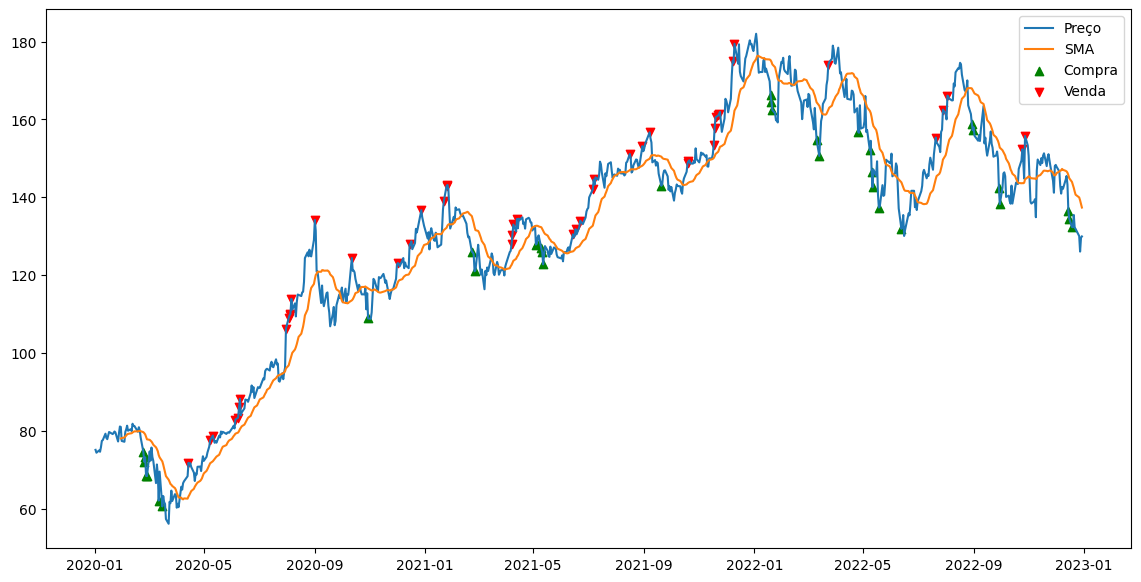

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Obtenha os dados históricos de um ativo (por exemplo, AAPL)
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

# Funções de cálculo
def calcula_SMA(precos, periodo):
    return precos.rolling(window=periodo).mean()

def calcula_desvio_padrao(precos, periodo):
    return precos.rolling(window=periodo).std()

def calcula_distorcao(preco_atual, sma, desvio_padrao):
    return (preco_atual - sma) / desvio_padrao

# Adicionando colunas ao DataFrame
data['SMA'] = calcula_SMA(data['Close'], 20)
data['DesvioPadrao'] = calcula_desvio_padrao(data['Close'], 20)
data['Distorcao'] = calcula_distorcao(data['Close'], data['SMA'], data['DesvioPadrao'])

# Definindo limites para alertas
limite_superior = 2
limite_inferior = -2

# Criação de alertas
data['Alerta'] = data['Distorcao'].apply(lambda x: 'Compra' if x < limite_inferior else ('Venda' if x > limite_superior else ''))

# Visualização
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Preço')
plt.plot(data.index, data['SMA'], label='SMA')
plt.scatter(data[data['Alerta'] == 'Compra'].index, data[data['Alerta'] == 'Compra']['Close'], label='Compra', marker='^', color='g')
plt.scatter(data[data['Alerta'] == 'Venda'].index, data[data['Alerta'] == 'Venda']['Close'], label='Venda', marker='v', color='r')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed


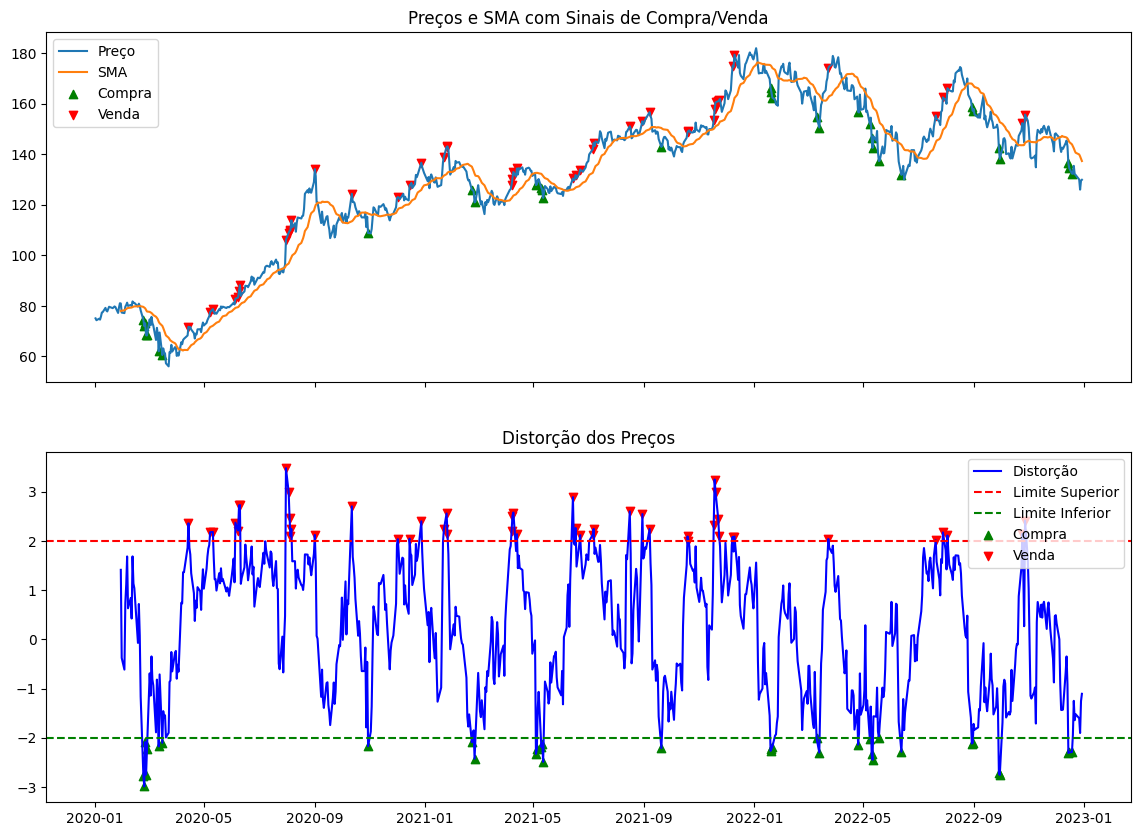

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Obtenha os dados históricos de um ativo (por exemplo, AAPL)
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

# Funções de cálculo
def calcula_SMA(precos, periodo):
    return precos.rolling(window=periodo).mean()

def calcula_desvio_padrao(precos, periodo):
    return precos.rolling(window=periodo).std()

def calcula_distorcao(preco_atual, sma, desvio_padrao):
    return (preco_atual - sma) / desvio_padrao

# Adicionando colunas ao DataFrame
data['SMA'] = calcula_SMA(data['Close'], 20)
data['DesvioPadrao'] = calcula_desvio_padrao(data['Close'], 20)
data['Distorcao'] = calcula_distorcao(data['Close'], data['SMA'], data['DesvioPadrao'])

# Definindo limites para alertas
limite_superior = 2
limite_inferior = -2

# Criação de alertas
data['Alerta'] = data['Distorcao'].apply(lambda x: 'Compra' if x < limite_inferior else ('Venda' if x > limite_superior else ''))

# Visualização
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10), sharex=True)

# Gráfico de preços
ax1.plot(data.index, data['Close'], label='Preço')
ax1.plot(data.index, data['SMA'], label='SMA')
ax1.scatter(data[data['Alerta'] == 'Compra'].index, data[data['Alerta'] == 'Compra']['Close'], label='Compra', marker='^', color='g')
ax1.scatter(data[data['Alerta'] == 'Venda'].index, data[data['Alerta'] == 'Venda']['Close'], label='Venda', marker='v', color='r')
ax1.set_title('Preços e SMA com Sinais de Compra/Venda')
ax1.legend()

# Gráfico de distorção
ax2.plot(data.index, data['Distorcao'], label='Distorção', color='blue')
ax2.axhline(y=limite_superior, color='r', linestyle='--', label='Limite Superior')
ax2.axhline(y=limite_inferior, color='g', linestyle='--', label='Limite Inferior')
ax2.scatter(data[data['Alerta'] == 'Compra'].index, data[data['Alerta'] == 'Compra']['Distorcao'], label='Compra', marker='^', color='g')
ax2.scatter(data[data['Alerta'] == 'Venda'].index, data[data['Alerta'] == 'Venda']['Distorcao'], label='Venda', marker='v', color='r')
ax2.set_title('Distorção dos Preços')
ax2.legend()

plt.show()

[*********************100%%**********************]  1 of 1 completed


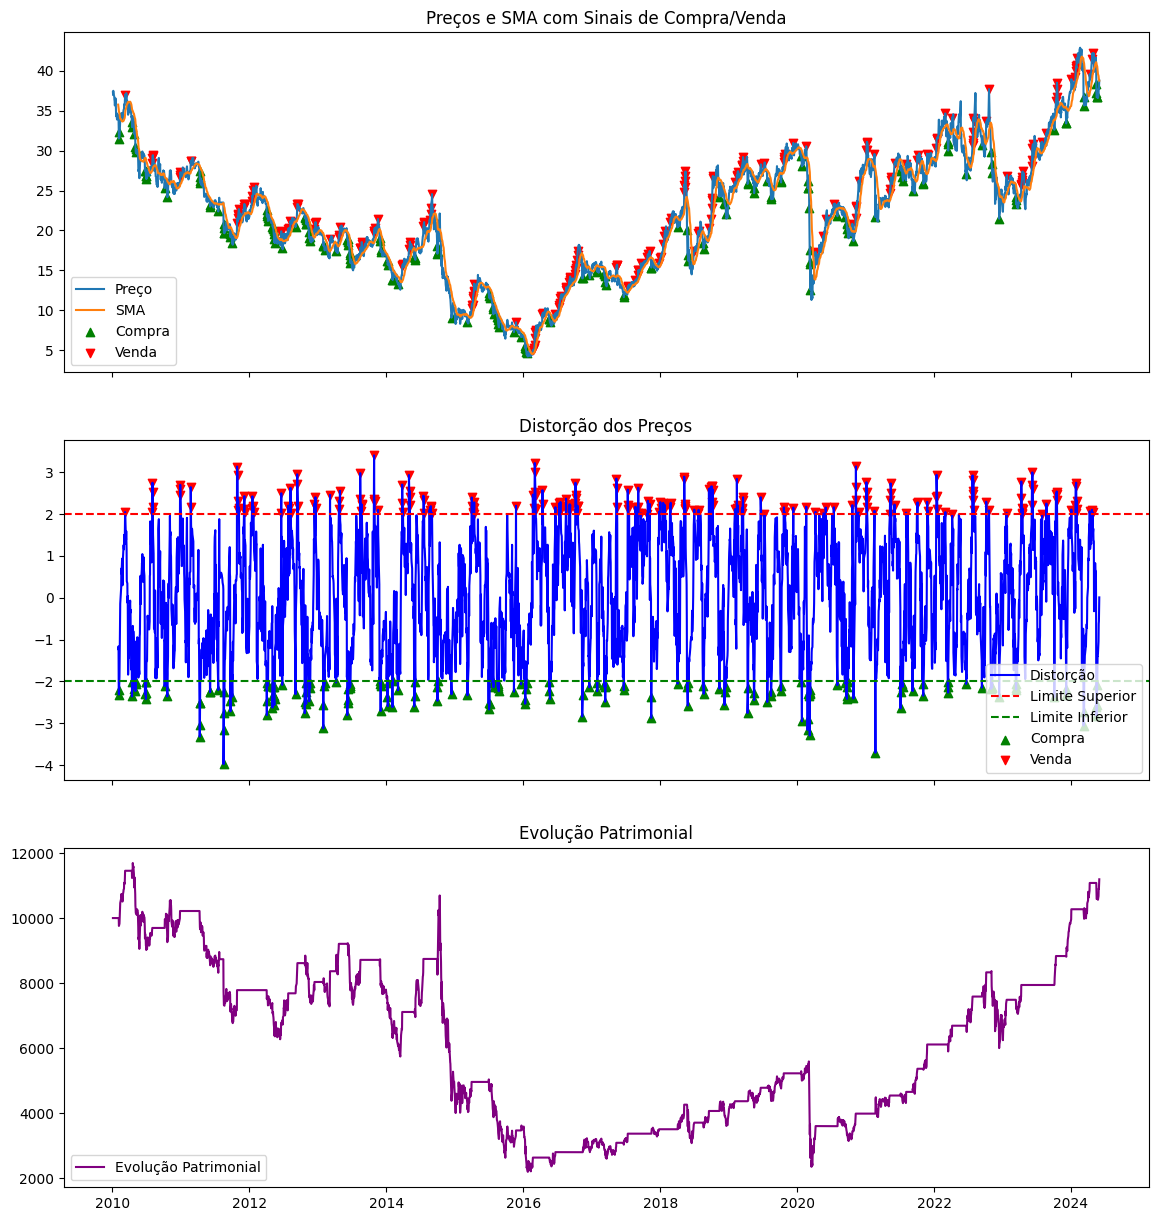

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Obtenha os dados históricos de um ativo (por exemplo, AAPL)
ticker = 'PETR4.SA'
data = yf.download(ticker, start='2010-01-01', end='2024-06-01')

# Funções de cálculo
def calcula_SMA(precos, periodo):
    return precos.rolling(window=periodo).mean()

def calcula_desvio_padrao(precos, periodo):
    return precos.rolling(window=periodo).std()

def calcula_distorcao(preco_atual, sma, desvio_padrao):
    return (preco_atual - sma) / desvio_padrao

# Adicionando colunas ao DataFrame
data['SMA'] = calcula_SMA(data['Close'], 20)
data['DesvioPadrao'] = calcula_desvio_padrao(data['Close'], 20)
data['Distorcao'] = calcula_distorcao(data['Close'], data['SMA'], data['DesvioPadrao'])

# Definindo limites para alertas
limite_superior = 2
limite_inferior = -2

# Criação de alertas
data['Alerta'] = data['Distorcao'].apply(lambda x: 'Compra' if x < limite_inferior else ('Venda' if x > limite_superior else ''))

# Inicializar parâmetros para simul⁷ação de patrimônio
capital_inicial = 10000  # Capital inicial em dólares
capital = capital_inicial
posicao = 0  # Quantidade de ações compradas
patrimonio = []

# Simulação do patrimônio ao longo do tempo
for i in range(len(data)):
    if data['Alerta'].iloc[i] == 'Compra' and capital > 0:
        # Compra: investir todo o capital em ações
        posicao = capital / data['Close'].iloc[i]
        capital = 0
    elif data['Alerta'].iloc[i] == 'Venda' and posicao > 0:
        # Venda: vender todas as ações
        capital = posicao * data['Close'].iloc[i]
        posicao = 0
    # Calcular o patrimônio total (ações + capital em dinheiro)
    patrimonio_total = capital + (posicao * data['Close'].iloc[i])
    patrimonio.append(patrimonio_total)

# Adicionar coluna de patrimônio ao DataFrame
data['Patrimonio'] = patrimonio

# Visualização
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(14, 15), sharex=True)

# Gráfico de preços
ax1.plot(data.index, data['Close'], label='Preço')
ax1.plot(data.index, data['SMA'], label='SMA')
ax1.scatter(data[data['Alerta'] == 'Compra'].index, data[data['Alerta'] == 'Compra']['Close'], label='Compra', marker='^', color='g')
ax1.scatter(data[data['Alerta'] == 'Venda'].index, data[data['Alerta'] == 'Venda']['Close'], label='Venda', marker='v', color='r')
ax1.set_title('Preços e SMA com Sinais de Compra/Venda')
ax1.legend()

# Gráfico de distorção
ax2.plot(data.index, data['Distorcao'], label='Distorção', color='blue')
ax2.axhline(y=limite_superior, color='r', linestyle='--', label='Limite Superior')
ax2.axhline(y=limite_inferior, color='g', linestyle='--', label='Limite Inferior')
ax2.scatter(data[data['Alerta'] == 'Compra'].index, data[data['Alerta'] == 'Compra']['Distorcao'], label='Compra', marker='^', color='g')
ax2.scatter(data[data['Alerta'] == 'Venda'].index, data[data['Alerta'] == 'Venda']['Distorcao'], label='Venda', marker='v', color='r')
ax2.set_title('Distorção dos Preços')
ax2.legend()

# Gráfico de evolução patrimonial
ax3.plot(data.index, data['Patrimonio'], label='Evolução Patrimonial', color='purple')
ax3.set_title('Evolução Patrimonial')
ax3.legend()

plt.show()

[*********************100%%**********************]  1 of 1 completed


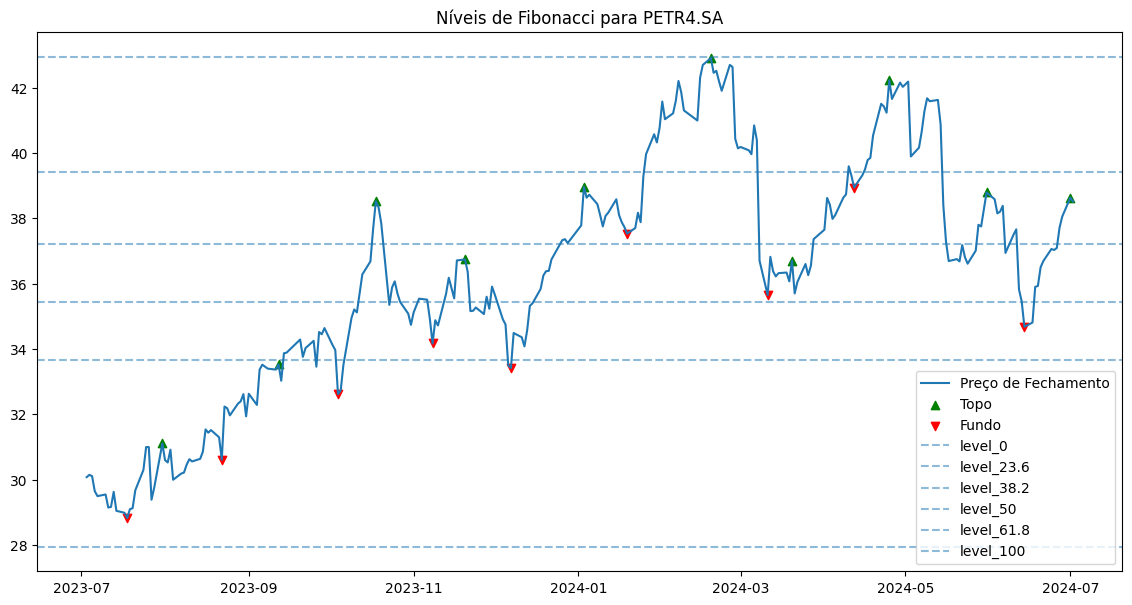

Venda em 2023-09-14 00:00:00 a 33.869998931884766
Venda em 2023-09-15 00:00:00 a 33.88999938964844
Venda em 2023-09-18 00:00:00 a 34.130001068115234
Venda em 2023-09-19 00:00:00 a 34.209999084472656
Venda em 2023-09-20 00:00:00 a 34.290000915527344
Venda em 2023-09-21 00:00:00 a 33.7599983215332
Venda em 2023-09-22 00:00:00 a 34.029998779296875
Venda em 2023-09-25 00:00:00 a 34.25
Venda em 2023-09-27 00:00:00 a 34.52000045776367
Venda em 2023-09-28 00:00:00 a 34.45000076293945
Venda em 2023-09-29 00:00:00 a 34.63999938964844
Venda em 2023-10-02 00:00:00 a 34.119998931884766
Venda em 2023-10-03 00:00:00 a 33.970001220703125
Venda em 2023-10-09 00:00:00 a 34.95000076293945
Venda em 2023-10-10 00:00:00 a 35.209999084472656
Venda em 2023-10-11 00:00:00 a 35.119998931884766
Compra em 2023-10-13 00:00:00 a 36.279998779296875
Compra em 2023-10-16 00:00:00 a 36.68000030517578
Venda em 2023-10-23 00:00:00 a 35.349998474121094
Compra em 2023-10-24 00:00:00 a 35.880001068115234
Compra em 2023-10-

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Função para obter dados históricos do Yahoo Finance
def get_historical_data(ticker, period='1y', interval='1d'):
    data = yf.download(ticker, period=period, interval=interval)
    return data

# Função para calcular níveis de Fibonacci
def calculate_fibonacci_levels(data):
    high_price = data['High'].max()
    low_price = data['Low'].min()
    diff = high_price - low_price

    levels = {
        'level_0': high_price,
        'level_23.6': high_price - 0.236 * diff,
        'level_38.2': high_price - 0.382 * diff,
        'level_50': high_price - 0.5 * diff,
        'level_61.8': high_price - 0.618 * diff,
        'level_100': low_price
    }
    return levels

# Função para identificar topos e fundos
def identify_peaks(data):
    peaks, _ = find_peaks(data['Close'], distance=20)
    troughs, _ = find_peaks(-data['Close'], distance=20)
    return peaks, troughs

# Função principal de trading
def trading_algorithm(ticker):
    data = get_historical_data(ticker)
    peaks, troughs = identify_peaks(data)
    levels = calculate_fibonacci_levels(data)

    # Plot dos dados e níveis de Fibonacci
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Preço de Fechamento')
    plt.scatter(data.iloc[peaks].index, data.iloc[peaks]['Close'], marker='^', color='g', label='Topo')
    plt.scatter(data.iloc[troughs].index, data.iloc[troughs]['Close'], marker='v', color='r', label='Fundo')

    for level in levels:
        plt.axhline(levels[level], linestyle='--', alpha=0.5, label=level)

    plt.legend()
    plt.title(f"Níveis de Fibonacci para {ticker}")
    plt.show()

    # Exemplo de lógica de entrada/saída (apenas para visualização)
    for i in range(len(data)):
        close_price = data['Close'][i]

        if close_price < levels['level_38.2'] and close_price > levels['level_50']:
            print(f"Compra em {data.index[i]} a {close_price}")

        if close_price > levels['level_61.8'] and close_price < levels['level_50']:
            print(f"Venda em {data.index[i]} a {close_price}")

# Executar o algoritmo para PETR4.SA
trading_algorithm('PETR4.SA')

[*********************100%%**********************]  1 of 1 completed


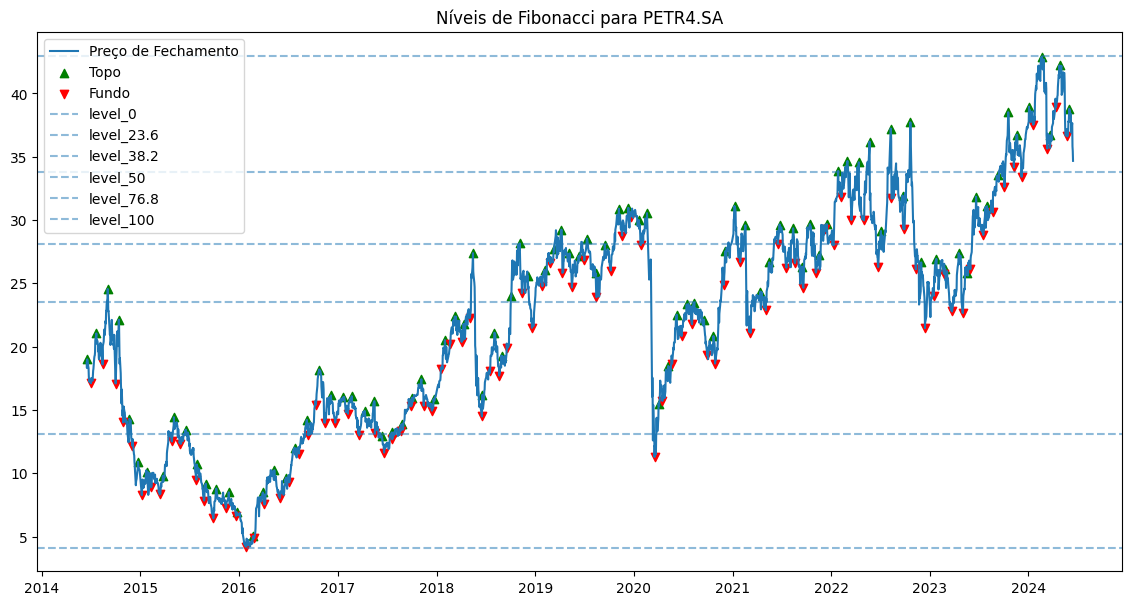

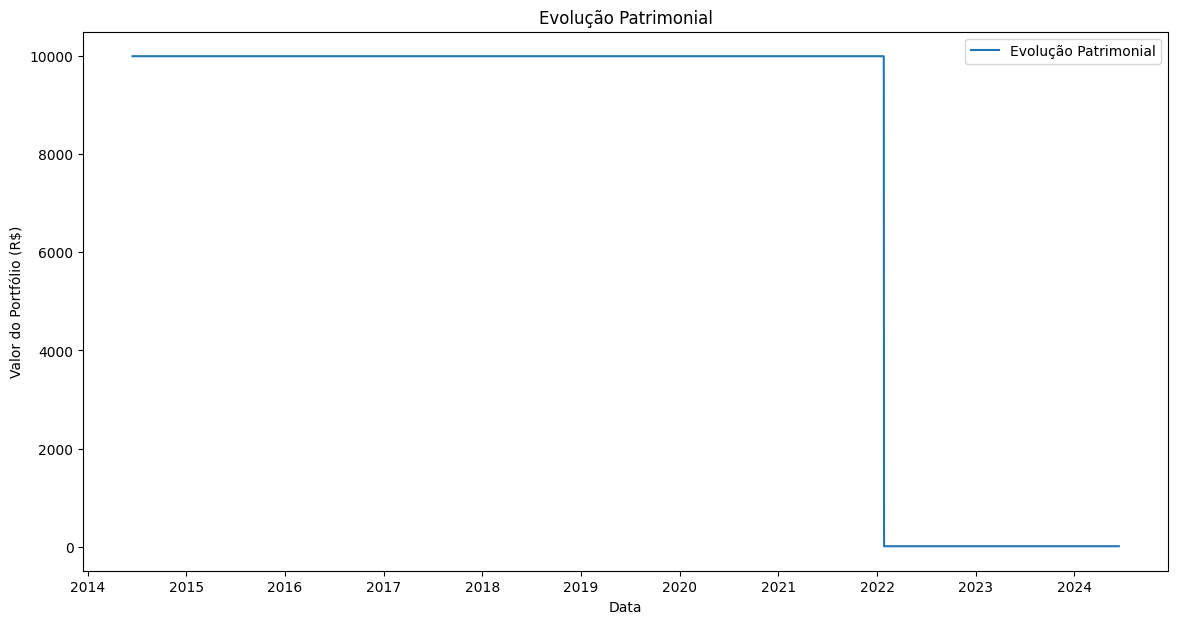

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Função para obter dados históricos do Yahoo Finance
def get_historical_data(ticker, period='10y', interval='1d'):
    data = yf.download(ticker, period=period, interval=interval)
    return data

# Função para calcular níveis de Fibonacci
def calculate_fibonacci_levels(data):
    high_price = data['High'].max()
    low_price = data['Low'].min()
    diff = high_price - low_price

    levels = {
        'level_0': high_price,
        'level_23.6': high_price - 0.236 * diff,
        'level_38.2': high_price - 0.382 * diff,
        'level_50': high_price - 0.5 * diff,
        'level_76.8': high_price - 0.768 * diff,
        'level_100': low_price
    }
    return levels

# Função para identificar topos e fundos
def identify_peaks(data):
    peaks, _ = find_peaks(data['Close'], distance=20)
    troughs, _ = find_peaks(-data['Close'], distance=20)
    return peaks, troughs

# Função principal de trading
def trading_algorithm(ticker, initial_capital=10000):
    data = get_historical_data(ticker)
    peaks, troughs = identify_peaks(data)
    levels = calculate_fibonacci_levels(data)

    capital = initial_capital
    position = 0  # Number of shares held
    portfolio_value = []

    for i in range(len(data)):
        close_price = data['Close'][i]

        if close_price < levels['level_0'] and close_price > levels['level_23.6'] and capital > 0:
            # Buy signal
            position = capital // close_price
            capital -= position * close_price

        if close_price > levels['level_100'] and close_price < levels['level_76.8'] and position > 0:
            # Sell signal
            capital += position * close_price
            position = 0

        portfolio_value.append(capital + position * close_price)

    # Plot dos dados e níveis de Fibonacci
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Preço de Fechamento')
    plt.scatter(data.iloc[peaks].index, data.iloc[peaks]['Close'], marker='^', color='g', label='Topo')
    plt.scatter(data.iloc[troughs].index, data.iloc[troughs]['Close'], marker='v', color='r', label='Fundo')

    for level in levels:
        plt.axhline(levels[level], linestyle='--', alpha=0.5, label=level)

    plt.legend()
    plt.title(f"Níveis de Fibonacci para {ticker}")
    plt.show()

    # Plot da evolução patrimonial
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, portfolio_value, label='Evolução Patrimonial')
    plt.title('Evolução Patrimonial')
    plt.xlabel('Data')
    plt.ylabel('Valor do Portfólio (R$)')
    plt.legend()
    plt.show()

# Executar o algoritmo para PETR4.SA
trading_algorithm('PETR4.SA')

[*********************100%%**********************]  1 of 1 completed


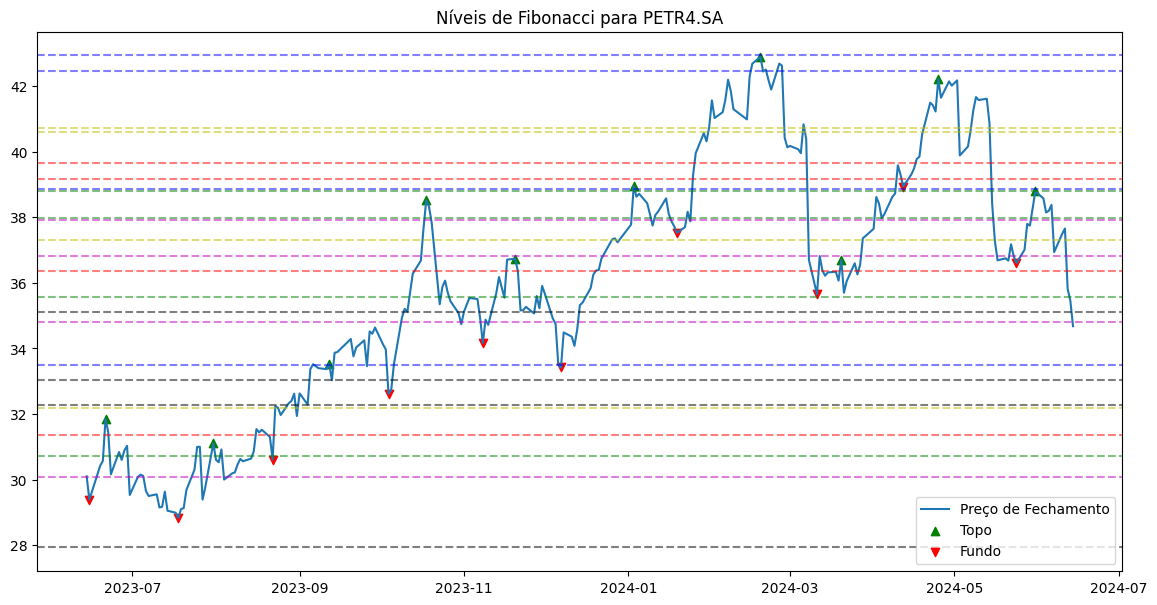

ValueError: x and y must have same first dimension, but have shapes (251,) and (240,)

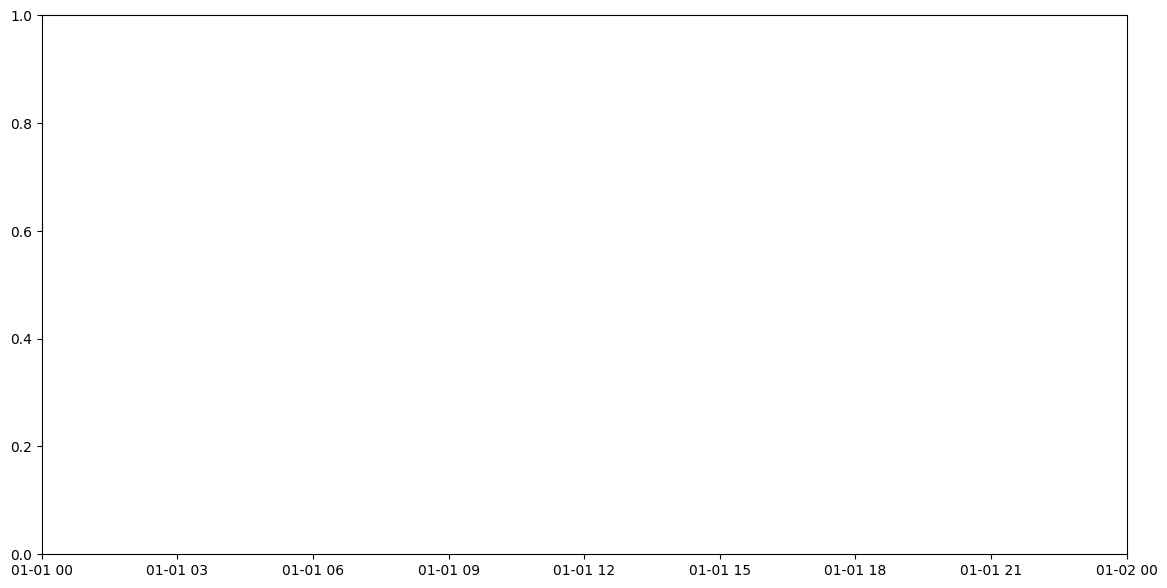

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Função para obter dados históricos do Yahoo Finance
def get_historical_data(ticker, period='1y', interval='1d'):
    data = yf.download(ticker, period=period, interval=interval)
    return data

# Função para calcular níveis de Fibonacci
def calculate_fibonacci_levels(high_price, low_price):
    diff = high_price - low_price

    levels = {
        'level_0': high_price,
        'level_23.6': high_price - 0.236 * diff,
        'level_38.2': high_price - 0.382 * diff,
        'level_50': high_price - 0.5 * diff,
        'level_61.8': high_price - 0.618 * diff,
        'level_100': low_price
    }
    return levels

# Função para identificar topos e fundos
def identify_peaks(data):
    peaks, _ = find_peaks(data['Close'], distance=20)
    troughs, _ = find_peaks(-data['Close'], distance=20)
    return peaks, troughs

# Função para calcular os níveis de Fibonacci em janelas menores
def calculate_fibonacci_levels_on_windows(data, window_size=60):
    fibonacci_levels = []
    for i in range(0, len(data), window_size):
        window = data.iloc[i:i + window_size]
        if len(window) < window_size:
            break
        high_price = window['High'].max()
        low_price = window['Low'].min()
        levels = calculate_fibonacci_levels(high_price, low_price)
        fibonacci_levels.append(levels)
    return fibonacci_levels

# Função principal de trading
def trading_algorithm(ticker, initial_capital=10000, window_size=60):
    data = get_historical_data(ticker)
    peaks, troughs = identify_peaks(data)
    fibonacci_levels = calculate_fibonacci_levels_on_windows(data, window_size=window_size)

    capital = initial_capital
    position = 0  # Number of shares held
    portfolio_value = []

    for i in range(len(data)):
        close_price = data['Close'][i]
        window_index = i // window_size
        if window_index >= len(fibonacci_levels):
            break
        levels = fibonacci_levels[window_index]

        if close_price < levels['level_38.2'] and close_price > levels['level_50'] and capital > 0:
            # Buy signal
            position = capital // close_price
            capital -= position * close_price

        if close_price > levels['level_61.8'] and close_price < levels['level_50'] and position > 0:
            # Sell signal
            capital += position * close_price
            position = 0

        portfolio_value.append(capital + position * close_price)

    # Plot dos dados e níveis de Fibonacci
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Preço de Fechamento')
    plt.scatter(data.iloc[peaks].index, data.iloc[peaks]['Close'], marker='^', color='g', label='Topo')
    plt.scatter(data.iloc[troughs].index, data.iloc[troughs]['Close'], marker='v', color='r', label='Fundo')

    for i, levels in enumerate(fibonacci_levels):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        plt.axhline(levels['level_0'], linestyle='--', alpha=0.5, color='b')
        plt.axhline(levels['level_23.6'], linestyle='--', alpha=0.5, color='y')
        plt.axhline(levels['level_38.2'], linestyle='--', alpha=0.5, color='r')
        plt.axhline(levels['level_50'], linestyle='--', alpha=0.5, color='g')
        plt.axhline(levels['level_61.8'], linestyle='--', alpha=0.5, color='m')
        plt.axhline(levels['level_100'], linestyle='--', alpha=0.5, color='k')

    plt.legend()
    plt.title(f"Níveis de Fibonacci para {ticker}")
    plt.show()

    # Plot da evolução patrimonial
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, portfolio_value, label='Evolução Patrimonial')
    plt.title('Evolução Patrimonial')
    plt.xlabel('Data')
    plt.ylabel('Valor do Portfólio (R$)')
    plt.legend()
    plt.show()

# Executar o algoritmo para PETR4.SA
trading_algorithm('PETR4.SA')

[*********************100%%**********************]  1 of 1 completed


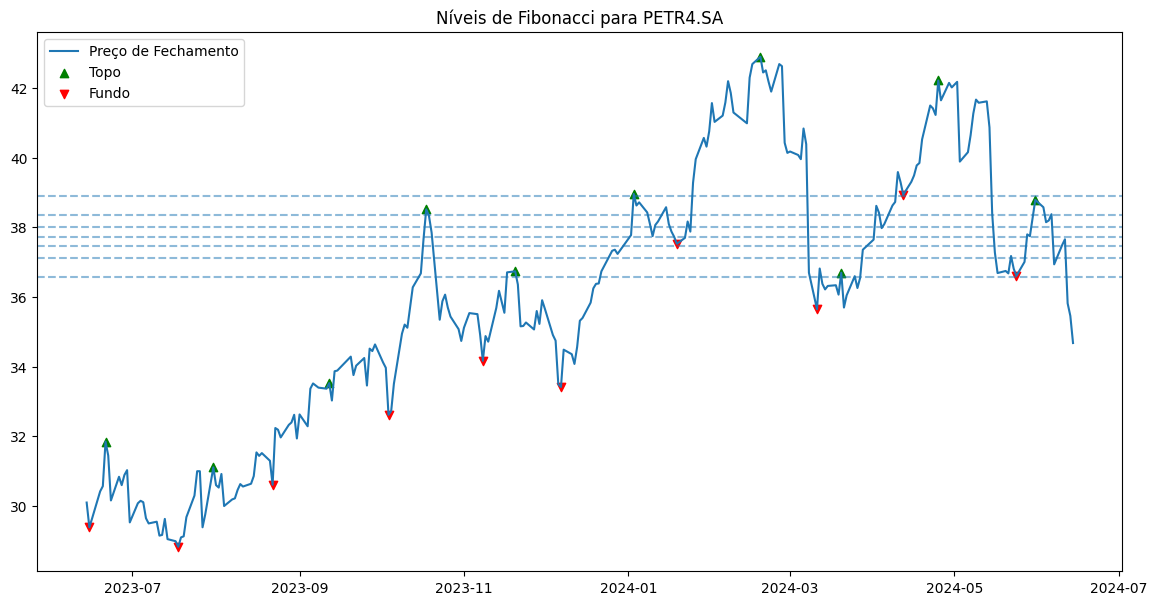

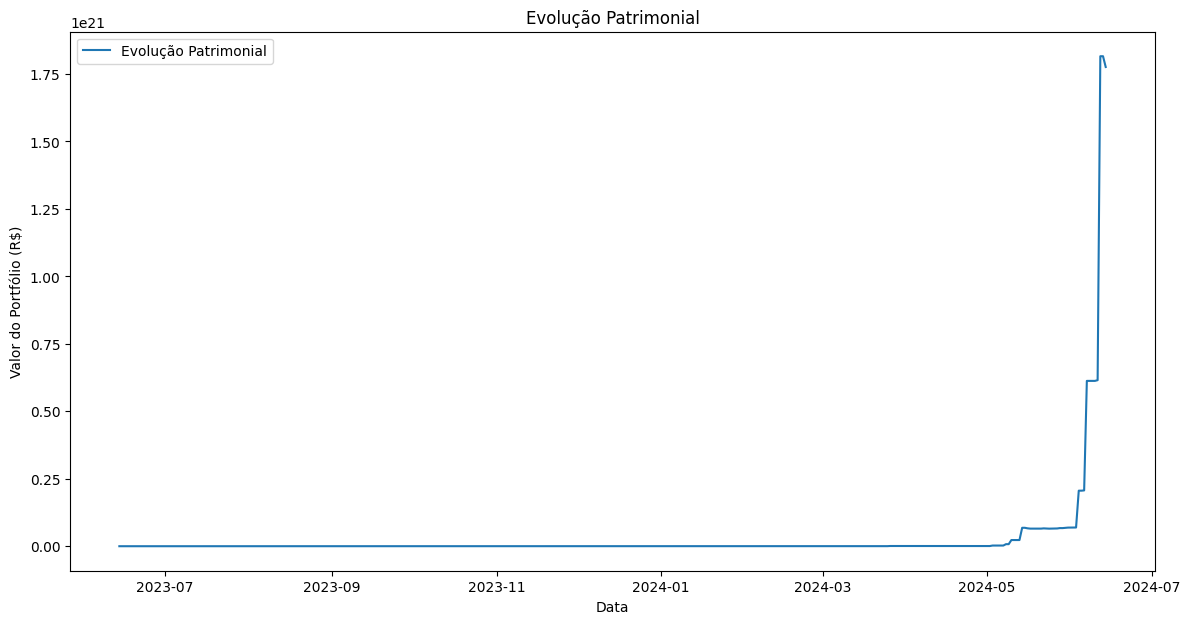

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Função para obter dados históricos do Yahoo Finance
def get_historical_data(ticker, period='1y', interval='1d'):
    data = yf.download(ticker, period=period, interval=interval)
    return data

# Função para calcular níveis de Fibonacci
def calculate_fibonacci_levels(high_price, low_price):
    diff = high_price - low_price

    levels = {
        'level_0': high_price,
        'level_23.6': high_price - 0.236 * diff,
        'level_38.2': high_price - 0.382 * diff,
        'level_50': high_price - 0.5 * diff,
        'level_61.8': high_price - 0.618 * diff,
        'level_76.8': high_price - 0.768 * diff,
        'level_100': low_price
    }
    return levels

# Função para identificar topos e fundos
def identify_peaks(data):
    peaks, _ = find_peaks(data['Close'], distance=20)
    troughs, _ = find_peaks(-data['Close'], distance=20)
    return peaks, troughs

# Função principal de trading
def trading_algorithm(ticker, initial_capital=10000):
    data = get_historical_data(ticker)
    peaks, troughs = identify_peaks(data)

    capital = initial_capital
    position = 0  # Number of shares held
    portfolio_value = []
    fib_levels = None
    last_peak = last_trough = None

    for i in range(len(data)):
        close_price = data['Close'][i]

        # Atualizar níveis de Fibonacci em novos topos ou fundos
        if i in peaks:
            high_price = data['High'][i]
            low_price = data['Low'][last_trough] if last_trough else data['Low'][0]
            fib_levels = calculate_fibonacci_levels(high_price, low_price)
            last_peak = i
        elif i in troughs:
            low_price = data['Low'][i]
            high_price = data['High'][last_peak] if last_peak else data['High'][0]
            fib_levels = calculate_fibonacci_levels(high_price, low_price)
            last_trough = i

        # Realizar operações de compra e venda
        if fib_levels:
            if close_price <= fib_levels['level_23.6'] and position == 0:
                # Buy signal at 23.6%
                position = capital // close_price
                capital -= position * close_price
            elif close_price >= fib_levels['level_76.8'] and position > 0:
                # Sell signal at 76.8%
                capital += position * close_price
                position = 0

            if close_price >= fib_levels['level_76.8'] and position == 0:
                # Sell signal at 76.8%
                position = -(capital // close_price)
                capital -= position * close_price
            elif close_price <= fib_levels['level_23.6'] and position < 0:
                # Close short position at 23.6%
                capital += -position * close_price
                position = 0

        portfolio_value.append(capital + position * close_price)

    # Plot dos dados e níveis de Fibonacci
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Preço de Fechamento')
    plt.scatter(data.iloc[peaks].index, data.iloc[peaks]['Close'], marker='^', color='g', label='Topo')
    plt.scatter(data.iloc[troughs].index, data.iloc[troughs]['Close'], marker='v', color='r', label='Fundo')

    if fib_levels:
        for level in fib_levels.values():
            plt.axhline(level, linestyle='--', alpha=0.5)

    plt.legend()
    plt.title(f"Níveis de Fibonacci para {ticker}")
    plt.show()

    # Plot da evolução patrimonial
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, portfolio_value, label='Evolução Patrimonial')
    plt.title('Evolução Patrimonial')
    plt.xlabel('Data')
    plt.ylabel('Valor do Portfólio (R$)')
    plt.legend()
    plt.show()

# Executar o algoritmo para PETR4.SA
trading_algorithm('PETR4.SA')

[*********************100%%**********************]  1 of 1 completed


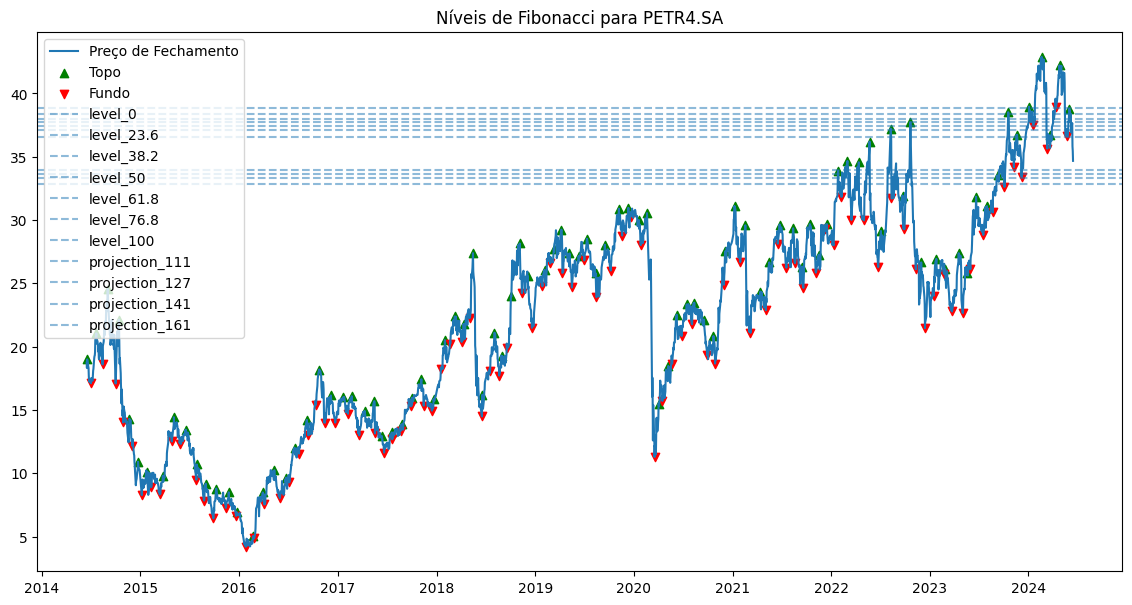

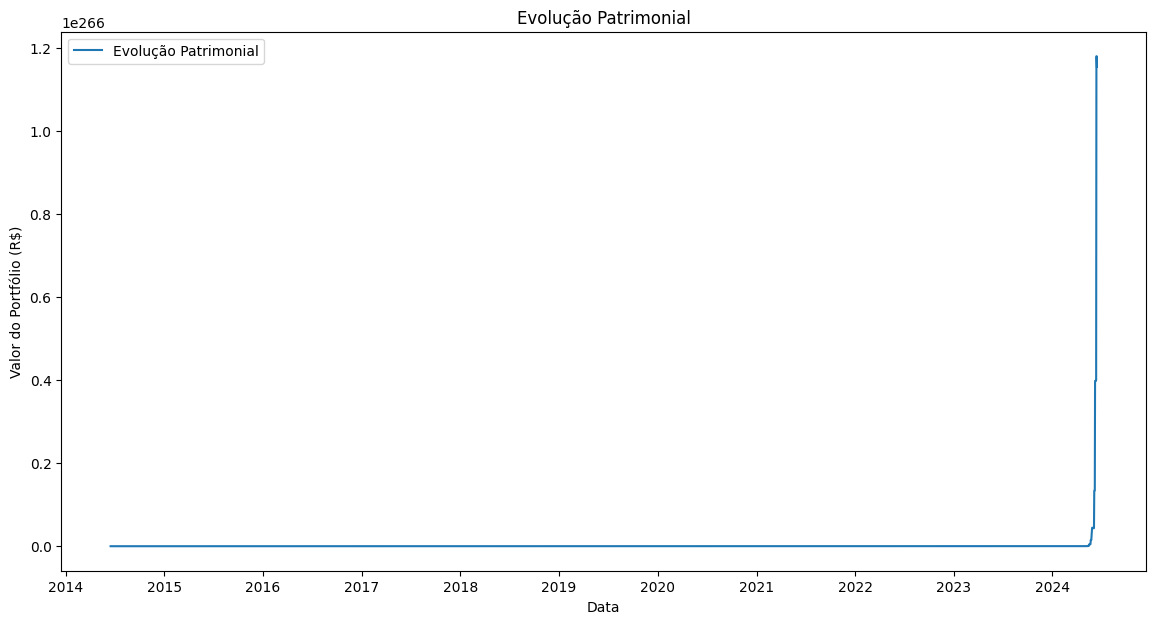

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Função para obter dados históricos do Yahoo Finance
def get_historical_data(ticker, period='10y', interval='1d'):
    data = yf.download(ticker, period=period, interval=interval)
    return data

# Função para calcular níveis de Fibonacci
def calculate_fibonacci_levels(high_price, low_price):
    diff = high_price - low_price

    levels = {
        'level_0': high_price,
        'level_23.6': high_price - 0.236 * diff,
        'level_38.2': high_price - 0.382 * diff,
        'level_50': high_price - 0.5 * diff,
        'level_61.8': high_price - 0.618 * diff,
        'level_76.8': high_price - 0.768 * diff,
        'level_100': low_price,
        'projection_111': low_price - 1.11 * diff,
        'projection_127': low_price - 1.27 * diff,
        'projection_141': low_price - 1.41 * diff,
        'projection_161': low_price - 1.61 * diff
    }
    return levels

# Função para identificar topos e fundos
def identify_peaks(data):
    peaks, _ = find_peaks(data['Close'], distance=20)
    troughs, _ = find_peaks(-data['Close'], distance=20)
    return peaks, troughs

# Função principal de trading
def trading_algorithm(ticker, initial_capital=10000):
    data = get_historical_data(ticker)
    peaks, troughs = identify_peaks(data)

    capital = initial_capital
    position = 0  # Number of shares held
    portfolio_value = []
    fib_levels = None
    last_peak = last_trough = None

    for i in range(len(data)):
        close_price = data['Close'][i]

        # Atualizar níveis de Fibonacci em novos topos ou fundos
        if i in peaks:
            high_price = data['High'][i]
            low_price = data['Low'][last_trough] if last_trough else data['Low'][0]
            fib_levels = calculate_fibonacci_levels(high_price, low_price)
            last_peak = i
        elif i in troughs:
            low_price = data['Low'][i]
            high_price = data['High'][last_peak] if last_peak else data['High'][0]
            fib_levels = calculate_fibonacci_levels(high_price, low_price)
            last_trough = i

        # Realizar operações de compra e venda
        if fib_levels:
            if close_price <= fib_levels['level_23.6'] and position == 0:
                # Buy signal at 23.6%
                position = capital // close_price
                capital -= position * close_price
            elif close_price >= fib_levels['projection_161'] and position > 0:
                # Sell signal at 76.8%
                capital += position * close_price
                position = 0

            if close_price >= fib_levels['projection_161'] and position == 0:
                # Sell signal at 76.8%
                position = -(capital // close_price)
                capital -= position * close_price
            elif close_price <= fib_levels['level_23.6'] and position < 0:
                # Close short position at 23.6%
                capital += -position * close_price
                position = 0

        portfolio_value.append(capital + position * close_price)

    # Plot dos dados e níveis de Fibonacci
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Preço de Fechamento')
    plt.scatter(data.iloc[peaks].index, data.iloc[peaks]['Close'], marker='^', color='g', label='Topo')
    plt.scatter(data.iloc[troughs].index, data.iloc[troughs]['Close'], marker='v', color='r', label='Fundo')

    if fib_levels:
        for level, value in fib_levels.items():
            plt.axhline(value, linestyle='--', alpha=0.5, label=level)

    plt.legend()
    plt.title(f"Níveis de Fibonacci para {ticker}")
    plt.show()

    # Plot da evolução patrimonial
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, portfolio_value, label='Evolução Patrimonial')
    plt.title('Evolução Patrimonial')
    plt.xlabel('Data')
    plt.ylabel('Valor do Portfólio (R$)')
    plt.legend()
    plt.show()

# Executar o algoritmo para PETR4.SA
trading_algorithm('PETR4.SA')

[*********************100%%**********************]  1 of 1 completed


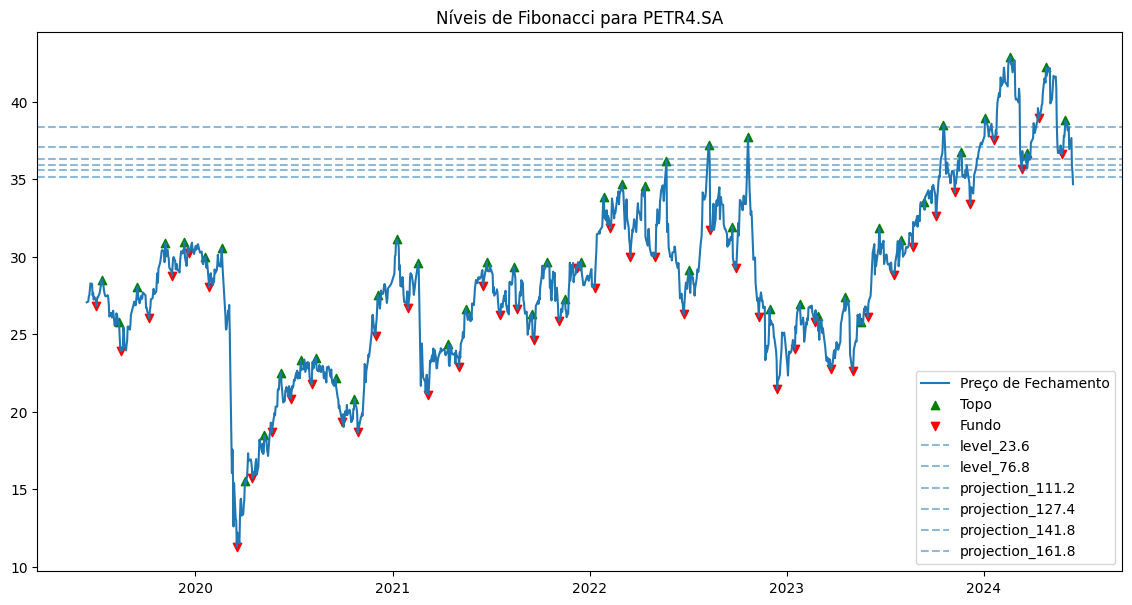

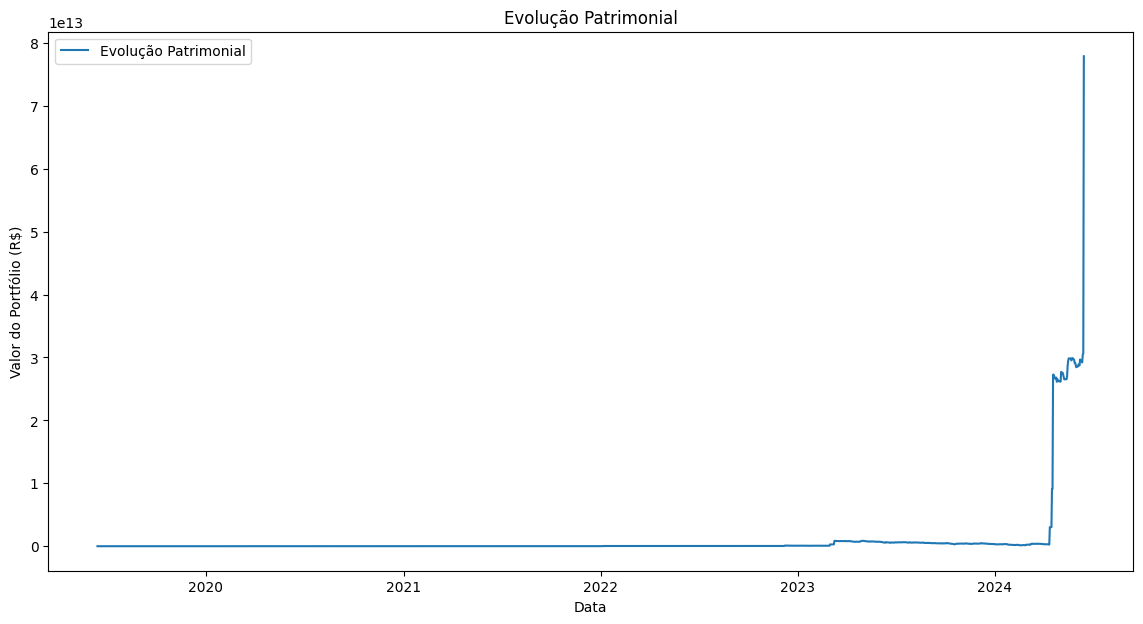

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Função para obter dados históricos do Yahoo Finance
def get_historical_data(ticker, period='5y', interval='1d'):
    data = yf.download(ticker, period=period, interval=interval)
    return data

# Função para calcular níveis de Fibonacci
def calculate_fibonacci_levels(high_price, low_price):
    diff = high_price - low_price

    levels = {
        'level_23.6': high_price - 0.236 * diff,
        'level_76.8': high_price - 0.768 * diff,
        'projection_111.2': low_price - 0.112 * diff,
        'projection_127.4': low_price - 0.274 * diff,
        'projection_141.8': low_price - 0.418 * diff,
        'projection_161.8': low_price - 0.618 * diff
    }
    return levels

# Função para identificar topos e fundos
def identify_peaks(data):
    peaks, _ = find_peaks(data['Close'], distance=20)
    troughs, _ = find_peaks(-data['Close'], distance=20)
    return peaks, troughs

# Função principal de trading
def trading_algorithm(ticker, initial_capital=10000):
    data = get_historical_data(ticker)
    peaks, troughs = identify_peaks(data)

    capital = initial_capital
    position = 0  # Number of shares held
    portfolio_value = []
    fib_levels = None
    last_peak = last_trough = None

    for i in range(len(data)):
        close_price = data['Close'][i]

        # Atualizar níveis de Fibonacci em novos topos ou fundos
        if i in peaks:
            high_price = data['High'][i]
            low_price = data['Low'][last_trough] if last_trough else data['Low'][0]
            fib_levels = calculate_fibonacci_levels(high_price, low_price)
            last_peak = i
        elif i in troughs:
            low_price = data['Low'][i]
            high_price = data['High'][last_peak] if last_peak else data['High'][0]
            fib_levels = calculate_fibonacci_levels(high_price, low_price)
            last_trough = i

        # Realizar operações de compra e venda
        if fib_levels:
            # Compra no nível 23.6 e vende no 76.8
            if close_price <= fib_levels['level_23.6'] and position == 0:
                position = capital // close_price
                capital -= position * close_price
            elif close_price >= fib_levels['level_76.8'] and position > 0:
                capital += position * close_price
                position = 0

            # Venda no nível 111.2 e fecha no 161.8
            if close_price >= fib_levels['projection_111.2'] and position == 0:
                position = -(capital // close_price)
                capital -= position * close_price
            elif close_price <= fib_levels['projection_161.8'] and position < 0:
                capital += -position * close_price
                position = 0

        portfolio_value.append(capital + position * close_price)

    # Plot dos dados e níveis de Fibonacci
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Preço de Fechamento')
    plt.scatter(data.iloc[peaks].index, data.iloc[peaks]['Close'], marker='^', color='g', label='Topo')
    plt.scatter(data.iloc[troughs].index, data.iloc[troughs]['Close'], marker='v', color='r', label='Fundo')

    if fib_levels:
        for level_name, level_value in fib_levels.items():
            plt.axhline(level_value, linestyle='--', alpha=0.5, label=level_name)

    plt.legend()
    plt.title(f"Níveis de Fibonacci para {ticker}")
    plt.show()

    # Plot da evolução patrimonial
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, portfolio_value, label='Evolução Patrimonial')
    plt.title('Evolução Patrimonial')
    plt.xlabel('Data')
    plt.ylabel('Valor do Portfólio (R$)')
    plt.legend()
    plt.show()

# Executar o algoritmo para PETR4.SA
trading_algorithm('PETR4.SA')

[*********************100%%**********************]  1 of 1 completed


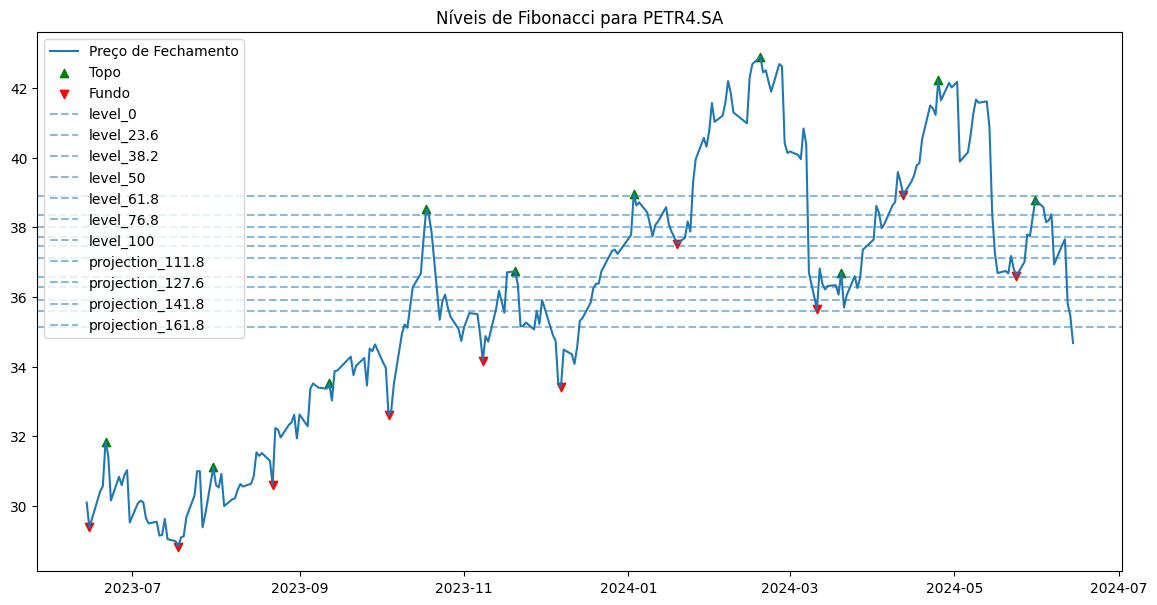

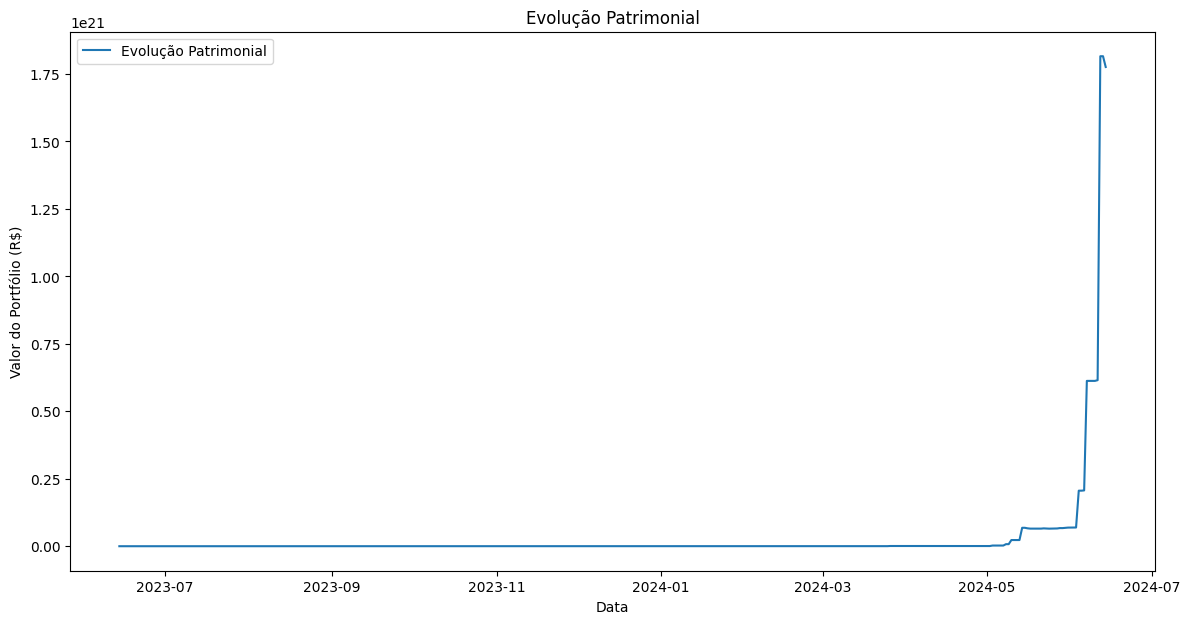

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Função para obter dados históricos do Yahoo Finance
def get_historical_data(ticker, period='1y', interval='1d'):
    data = yf.download(ticker, period=period, interval=interval)
    return data

# Função para calcular níveis de Fibonacci
def calculate_fibonacci_levels(high_price, low_price):
    diff = high_price - low_price

    levels = {
        'level_0': high_price,
        'level_23.6': high_price - 0.236 * diff,
        'level_38.2': high_price - 0.382 * diff,
        'level_50': high_price - 0.5 * diff,
        'level_61.8': high_price - 0.618 * diff,
        'level_76.8': high_price - 0.768 * diff,
        'level_100': low_price,
        'projection_111.8': low_price - 0.118 * diff,
        'projection_127.6': low_price - 0.276 * diff,
        'projection_141.8': low_price - 0.418 * diff,
        'projection_161.8': low_price - 0.618 * diff
    }
    return levels

# Função para identificar topos e fundos
def identify_peaks(data):
    peaks, _ = find_peaks(data['Close'], distance=20)
    troughs, _ = find_peaks(-data['Close'], distance=20)
    return peaks, troughs

# Função principal de trading
def trading_algorithm(ticker, initial_capital=10000):
    data = get_historical_data(ticker)
    peaks, troughs = identify_peaks(data)

    capital = initial_capital
    position = 0  # Number of shares held
    portfolio_value = []
    fib_levels = None
    last_peak = last_trough = None

    for i in range(len(data)):
        close_price = data['Close'][i]

        # Atualizar níveis de Fibonacci em novos topos ou fundos
        if i in peaks:
            high_price = data['High'][i]
            low_price = data['Low'][last_trough] if last_trough else data['Low'][0]
            fib_levels = calculate_fibonacci_levels(high_price, low_price)
            last_peak = i
        elif i in troughs:
            low_price = data['Low'][i]
            high_price = data['High'][last_peak] if last_peak else data['High'][0]
            fib_levels = calculate_fibonacci_levels(high_price, low_price)
            last_trough = i

        # Realizar operações de compra e venda
        if fib_levels:
            if close_price <= fib_levels['level_23.6'] and position == 0:
                # Buy signal at 23.6%
                position = capital // close_price
                capital -= position * close_price
            elif close_price >= fib_levels['level_76.8'] and position > 0:
                # Sell signal at 76.8%
                capital += position * close_price
                position = 0

            if close_price >= fib_levels['level_76.8'] and position == 0:
                # Sell signal at 76.8%
                position = -(capital // close_price)
                capital -= position * close_price
            elif close_price <= fib_levels['level_23.6'] and position < 0:
                # Close short position at 23.6%
                capital += -position * close_price
                position = 0

        portfolio_value.append(capital + position * close_price)

    # Plot dos dados e níveis de Fibonacci
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Preço de Fechamento')
    plt.scatter(data.iloc[peaks].index, data.iloc[peaks]['Close'], marker='^', color='g', label='Topo')
    plt.scatter(data.iloc[troughs].index, data.iloc[troughs]['Close'], marker='v', color='r', label='Fundo')

    if fib_levels:
        for level_name, level_value in fib_levels.items():
            plt.axhline(level_value, linestyle='--', alpha=0.5, label=level_name)

    plt.legend()
    plt.title(f"Níveis de Fibonacci para {ticker}")
    plt.show()

    # Plot da evolução patrimonial
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, portfolio_value, label='Evolução Patrimonial')
    plt.title('Evolução Patrimonial')
    plt.xlabel('Data')
    plt.ylabel('Valor do Portfólio (R$)')
    plt.legend()
    plt.show()

# Executar o algoritmo para PETR4.SA
trading_algorithm('PETR4.SA')

[*********************100%%**********************]  1 of 1 completed


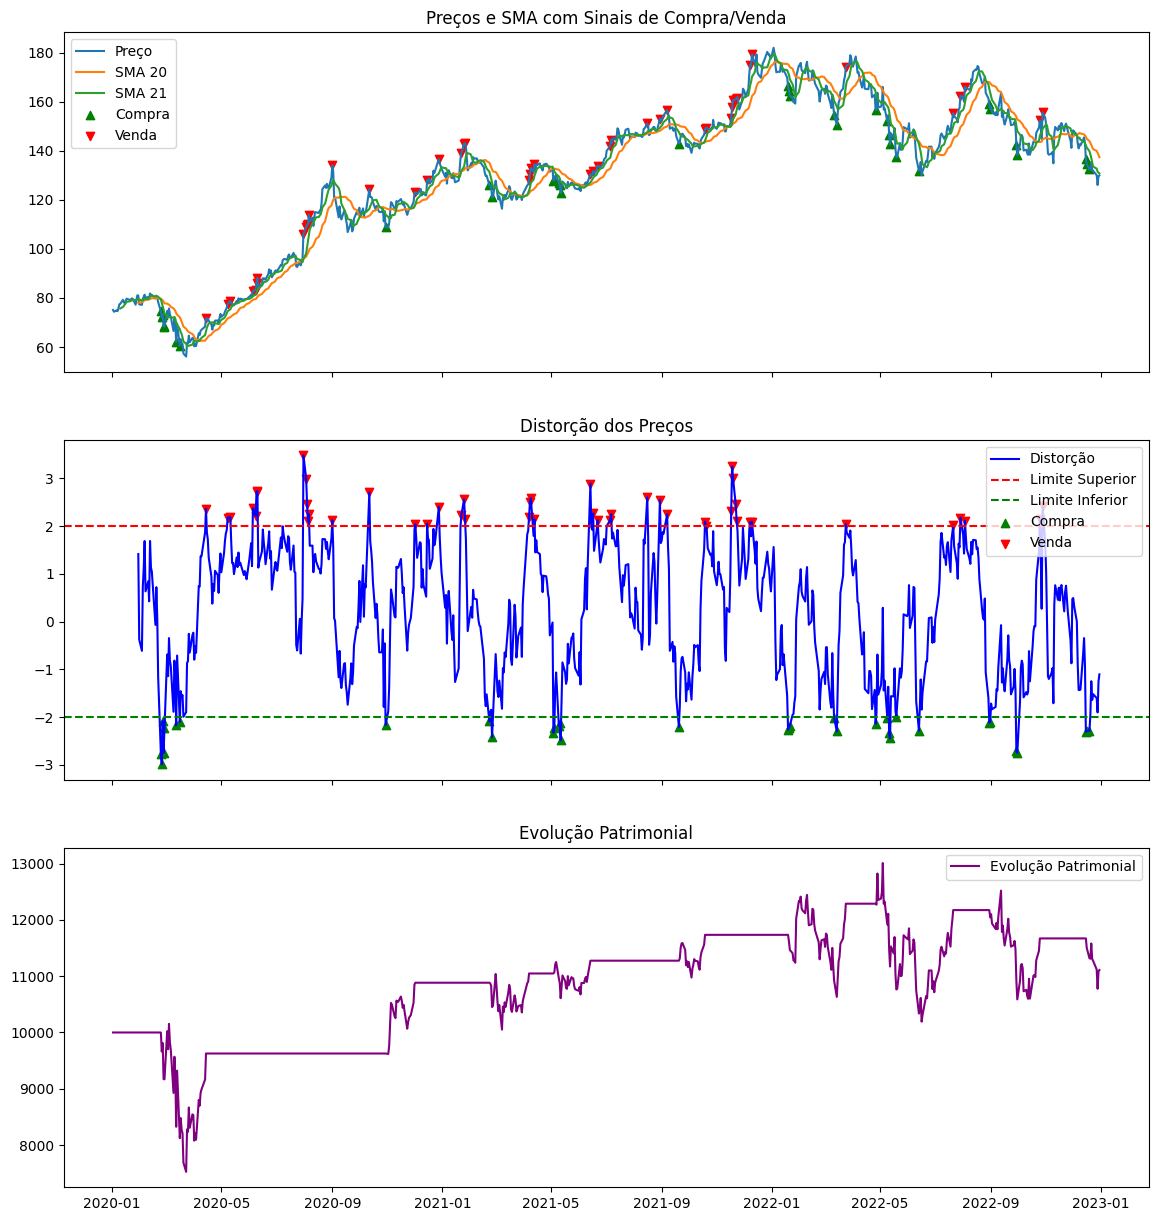

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Obtenha os dados históricos de um ativo (por exemplo, AAPL)
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

# Funções de cálculo
def calcula_SMA(precos, periodo):
    return precos.rolling(window=periodo).mean()

def calcula_desvio_padrao(precos, periodo):
    return precos.rolling(window=periodo).std()

def calcula_distorcao(preco_atual, sma, desvio_padrao):
    return (preco_atual - sma) / desvio_padrao

# Adicionando colunas ao DataFrame
data['SMA_20'] = calcula_SMA(data['Close'], 20)
data['SMA_21'] = calcula_SMA(data['Close'], 7)
data['DesvioPadrao'] = calcula_desvio_padrao(data['Close'], 20)
data['Distorcao'] = calcula_distorcao(data['Close'], data['SMA_20'], data['DesvioPadrao'])

# Definindo limites para alertas
limite_superior = 2
limite_inferior = -2

# Criação de alertas com filtro de SMA_21
def filtra_alertas(row):
    if row['Close'] < row['SMA_21']:
        if row['Distorcao'] < limite_inferior:
            return 'Compra'
    elif row['Close'] > row['SMA_21']:
        if row['Distorcao'] > limite_superior:
            return 'Venda'
    return ''

data['Alerta'] = data.apply(filtra_alertas, axis=1)

# Inicializar parâmetros para simulação de patrimônio
capital_inicial = 10000  # Capital inicial em dólares
capital = capital_inicial
posicao = 0  # Quantidade de ações compradas
patrimonio = []

# Simulação do patrimônio ao longo do tempo
for i in range(len(data)):
    if data['Alerta'].iloc[i] == 'Compra' and capital > 0:
        # Compra: investir todo o capital em ações
        posicao = capital / data['Close'].iloc[i]
        capital = 0
    elif data['Alerta'].iloc[i] == 'Venda' and posicao > 0:
        # Venda: vender todas as ações
        capital = posicao * data['Close'].iloc[i]
        posicao = 0
    # Calcular o patrimônio total (ações + capital em dinheiro)
    patrimonio_total = capital + (posicao * data['Close'].iloc[i])
    patrimonio.append(patrimonio_total)

# Adicionar coluna de patrimônio ao DataFrame
data['Patrimonio'] = patrimonio

# Visualização
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(14, 15), sharex=True)

# Gráfico de preços
ax1.plot(data.index, data['Close'], label='Preço')
ax1.plot(data.index, data['SMA_20'], label='SMA 20')
ax1.plot(data.index, data['SMA_21'], label='SMA 21')
ax1.scatter(data[data['Alerta'] == 'Compra'].index, data[data['Alerta'] == 'Compra']['Close'], label='Compra', marker='^', color='g')
ax1.scatter(data[data['Alerta'] == 'Venda'].index, data[data['Alerta'] == 'Venda']['Close'], label='Venda', marker='v', color='r')
ax1.set_title('Preços e SMA com Sinais de Compra/Venda')
ax1.legend()

# Gráfico de distorção
ax2.plot(data.index, data['Distorcao'], label='Distorção', color='blue')
ax2.axhline(y=limite_superior, color='r', linestyle='--', label='Limite Superior')
ax2.axhline(y=limite_inferior, color='g', linestyle='--', label='Limite Inferior')
ax2.scatter(data[data['Alerta'] == 'Compra'].index, data[data['Alerta'] == 'Compra']['Distorcao'], label='Compra', marker='^', color='g')
ax2.scatter(data[data['Alerta'] == 'Venda'].index, data[data['Alerta'] == 'Venda']['Distorcao'], label='Venda', marker='v', color='r')
ax2.set_title('Distorção dos Preços')
ax2.legend()

# Gráfico de evolução patrimonial
ax3.plot(data.index, data['Patrimonio'], label='Evolução Patrimonial', color='purple')
ax3.set_title('Evolução Patrimonial')
ax3.legend()

plt.show()

[*********************100%%**********************]  1 of 1 completed
<ipython-input-7-08d6d36419f3>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fase'].iloc[i] = 'Baixa'
<ipython-input-7-08d6d36419f3>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fase'].iloc[i] = 'Alta'
<ipython-input-7-08d6d36419f3>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fase'].iloc[i] = 'Baixa'
<ipython-input-7-08d6d36419f3>:38: Settin

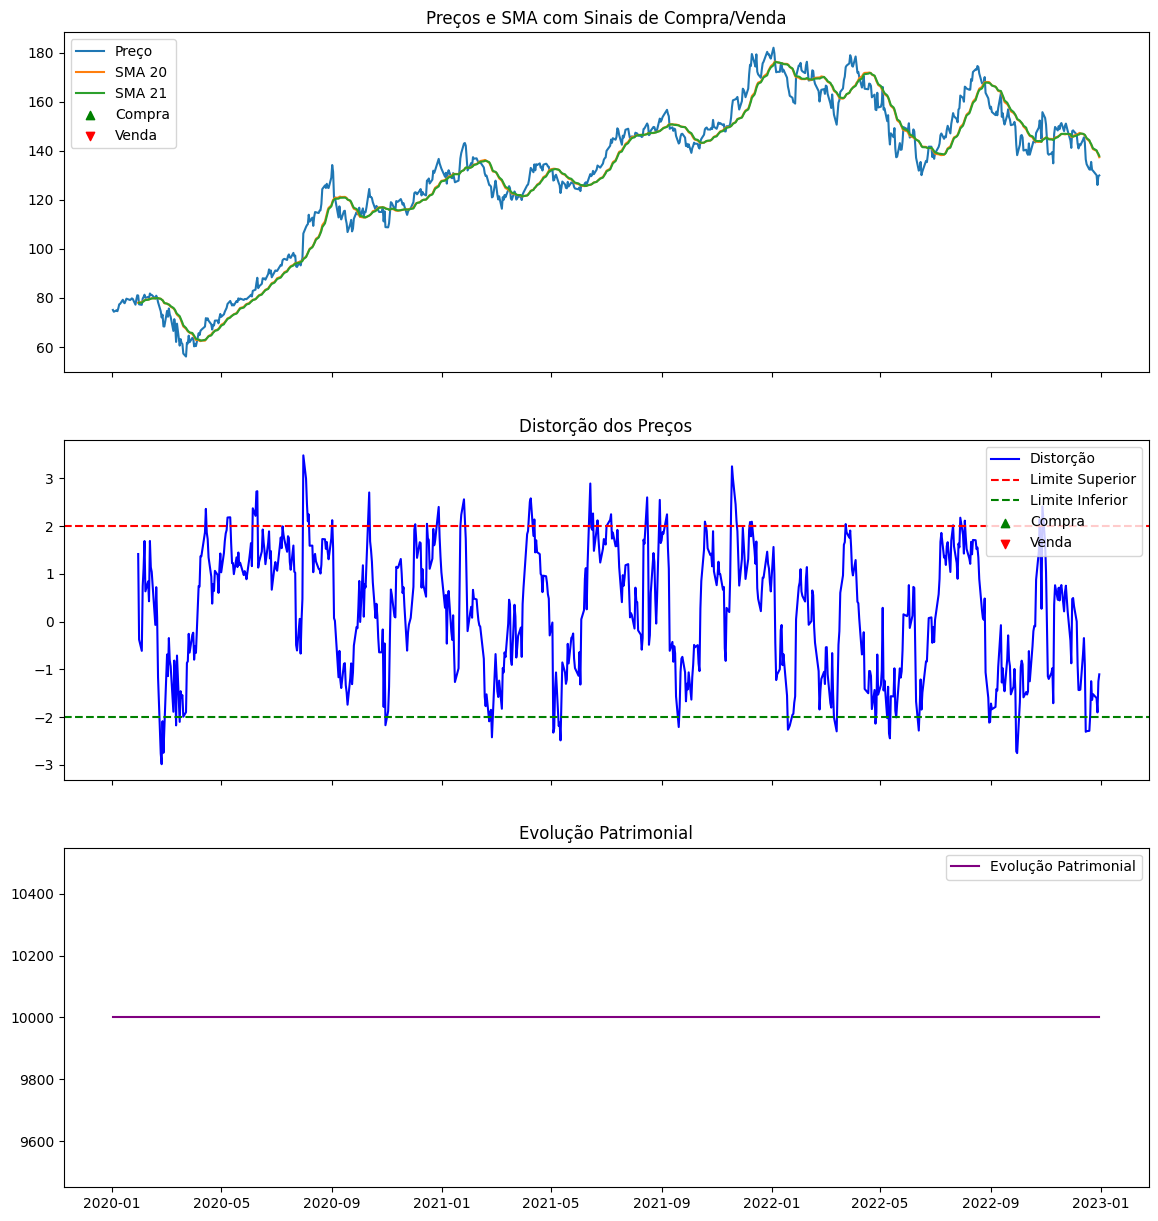

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Obtenha os dados históricos de um ativo (por exemplo, AAPL)
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

# Funções de cálculo
def calcula_SMA(precos, periodo):
    return precos.rolling(window=periodo).mean()

def calcula_desvio_padrao(precos, periodo):
    return precos.rolling(window=periodo).std()

def calcula_distorcao(preco_atual, sma, desvio_padrao):
    return (preco_atual - sma) / desvio_padrao

# Adicionando colunas ao DataFrame
data['SMA_20'] = calcula_SMA(data['Close'], 20)
data['SMA_21'] = calcula_SMA(data['Close'], 21)
data['DesvioPadrao'] = calcula_desvio_padrao(data['Close'], 20)
data['Distorcao'] = calcula_distorcao(data['Close'], data['SMA_20'], data['DesvioPadrao'])

# Definindo limites para alertas
limite_superior = 2
limite_inferior = -2

# Identificação das fases de Wyckoff
def identifica_fase_wyckoff(df):
    df['Fase'] = ''
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['SMA_21'].iloc[i] and df['Close'].iloc[i-1] <= df['SMA_21'].iloc[i-1]:
            df['Fase'].iloc[i] = 'Acumulação'
        elif df['Close'].iloc[i] < df['SMA_21'].iloc[i] and df['Close'].iloc[i-1] >= df['SMA_21'].iloc[i-1]:
            df['Fase'].iloc[i] = 'Distribuição'
        elif df['Close'].iloc[i] > df['Close'].iloc[i-1]:
            df['Fase'].iloc[i] = 'Alta'
        else:
            df['Fase'].iloc[i] = 'Baixa'
    return df

data = identifica_fase_wyckoff(data)

# Criação de alertas com filtro de SMA_21 e fases de Wyckoff
def filtra_alertas(row):
    if row['Fase'] == 'Acumulação' and row['Distorcao'] < limite_inferior:
        return 'Compra'
    elif row['Fase'] == 'Distribuição' and row['Distorcao'] > limite_superior:
        return 'Venda'
    return ''

data['Alerta'] = data.apply(filtra_alertas, axis=1)

# Inicializar parâmetros para simulação de patrimônio
capital_inicial = 10000  # Capital inicial em dólares
capital = capital_inicial
posicao = 0  # Quantidade de ações compradas
patrimonio = []

# Simulação do patrimônio ao longo do tempo
for i in range(len(data)):
    if data['Alerta'].iloc[i] == 'Compra' and capital > 0:
        # Compra: investir todo o capital em ações
        posicao = capital / data['Close'].iloc[i]
        capital = 0
    elif data['Alerta'].iloc[i] == 'Venda' and posicao > 0:
        # Venda: vender todas as ações
        capital = posicao * data['Close'].iloc[i]
        posicao = 0
    # Calcular o patrimônio total (ações + capital em dinheiro)
    patrimonio_total = capital + (posicao * data['Close'].iloc[i])
    patrimonio.append(patrimonio_total)

# Adicionar coluna de patrimônio ao DataFrame
data['Patrimonio'] = patrimonio

# Visualização
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(14, 15), sharex=True)

# Gráfico de preços
ax1.plot(data.index, data['Close'], label='Preço')
ax1.plot(data.index, data['SMA_20'], label='SMA 20')
ax1.plot(data.index, data['SMA_21'], label='SMA 21')
ax1.scatter(data[data['Alerta'] == 'Compra'].index, data[data['Alerta'] == 'Compra']['Close'], label='Compra', marker='^', color='g')
ax1.scatter(data[data['Alerta'] == 'Venda'].index, data[data['Alerta'] == 'Venda']['Close'], label='Venda', marker='v', color='r')
ax1.set_title('Preços e SMA com Sinais de Compra/Venda')
ax1.legend()

# Gráfico de distorção
ax2.plot(data.index, data['Distorcao'], label='Distorção', color='blue')
ax2.axhline(y=limite_superior, color='r', linestyle='--', label='Limite Superior')
ax2.axhline(y=limite_inferior, color='g', linestyle='--', label='Limite Inferior')
ax2.scatter(data[data['Alerta'] == 'Compra'].index, data[data['Alerta'] == 'Compra']['Distorcao'], label='Compra', marker='^', color='g')
ax2.scatter(data[data['Alerta'] == 'Venda'].index, data[data['Alerta'] == 'Venda']['Distorcao'], label='Venda', marker='v', color='r')
ax2.set_title('Distorção dos Preços')
ax2.legend()

# Gráfico de evolução patrimonial
ax3.plot(data.index, data['Patrimonio'], label='Evolução Patrimonial', color='purple')
ax3.set_title('Evolução Patrimonial')
ax3.legend()

plt.show()

[*********************100%%**********************]  1 of 1 completed
<ipython-input-22-17239676c23c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fase'].iloc[i] = 'Baixa'
<ipython-input-22-17239676c23c>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fase'].iloc[i] = 'Alta'
<ipython-input-22-17239676c23c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fase'].iloc[i] = 'Baixa'
<ipython-input-22-17239676c23c>:35: Se

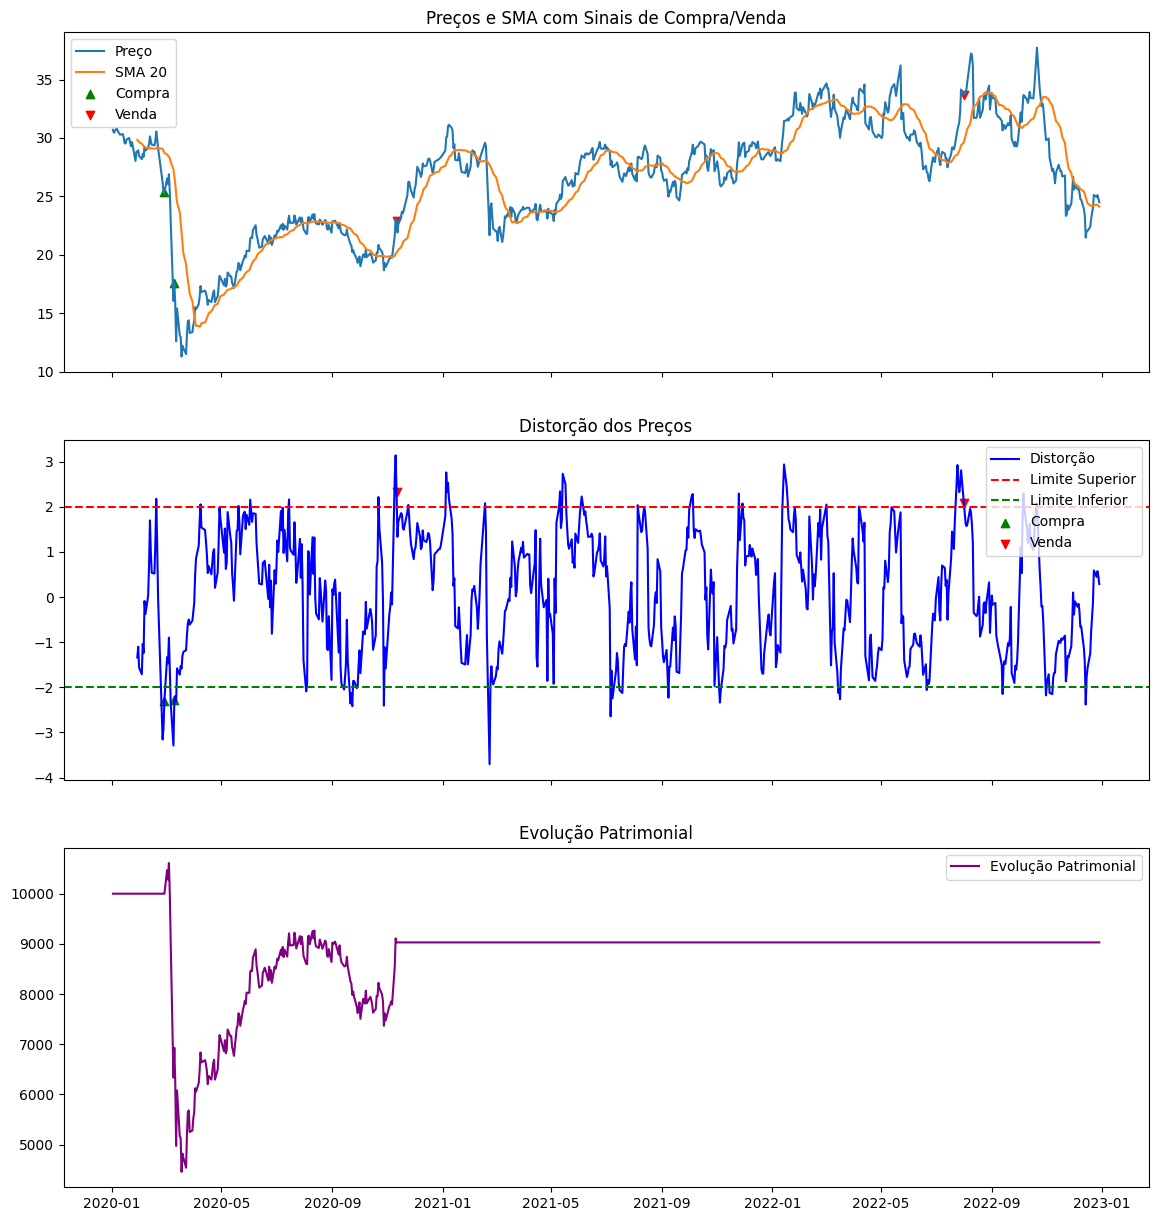

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Obtenha os dados históricos de um ativo (por exemplo, AAPL)
ticker = 'PETR4.SA'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

# Funções de cálculo
def calcula_SMA(precos, periodo):
    return precos.rolling(window=periodo).mean()

def calcula_desvio_padrao(precos, periodo):
    return precos.rolling(window=periodo).std()

def calcula_distorcao(preco_atual, sma, desvio_padrao):
    return (preco_atual - sma) / desvio_padrao

# Adicionando colunas ao DataFrame
data['SMA_20'] = calcula_SMA(data['Close'], 20)
data['DesvioPadrao'] = calcula_desvio_padrao(data['Close'], 20)
data['Distorcao'] = calcula_distorcao(data['Close'], data['SMA_20'], data['DesvioPadrao'])

# Definindo limites para alertas
limite_superior = 2
limite_inferior = -2

# Identificação das fases de Wyckoff
def identifica_fase_wyckoff(df):
    df['Fase'] = ''
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i-1]:
            df['Fase'].iloc[i] = 'Alta'
        elif df['Close'].iloc[i] < df['Close'].iloc[i-1]:
            df['Fase'].iloc[i] = 'Baixa'
        else:
            df['Fase'].iloc[i] = df['Fase'].iloc[i-1]  # Mantém a fase anterior se o preço não mudar
    return df

data = identifica_fase_wyckoff(data)

# Criação de alertas com base nas fases de Wyckoff
def filtra_alertas(row):
    if row['Fase'] == 'Alta' and row['Distorcao'] < limite_inferior:
        return 'Compra'
    elif row['Fase'] == 'Baixa' and row['Distorcao'] > limite_superior:
        return 'Venda'
    return ''

data['Alerta'] = data.apply(filtra_alertas, axis=1)

# Inicializar parâmetros para simulação de patrimônio
capital_inicial = 10000  # Capital inicial em dólares
capital = capital_inicial
posicao = 0  # Quantidade de ações compradas
patrimonio = []

# Simulação do patrimônio ao longo do tempo
for i in range(len(data)):
    if data['Alerta'].iloc[i] == 'Compra' and capital > 0:
        # Compra: investir todo o capital em ações
        posicao = capital / data['Close'].iloc[i]
        capital = 0
    elif data['Alerta'].iloc[i] == 'Venda' and posicao > 0:
        # Venda: vender todas as ações
        capital = posicao * data['Close'].iloc[i]
        posicao = 0
    # Calcular o patrimônio total (ações + capital em dinheiro)
    patrimonio_total = capital + (posicao * data['Close'].iloc[i])
    patrimonio.append(patrimonio_total)

# Adicionar coluna de patrimônio ao DataFrame
data['Patrimonio'] = patrimonio

# Visualização
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(14, 15), sharex=True)

# Gráfico de preços
ax1.plot(data.index, data['Close'], label='Preço')
ax1.plot(data.index, data['SMA_20'], label='SMA 20')
ax1.scatter(data[data['Alerta'] == 'Compra'].index, data[data['Alerta'] == 'Compra']['Close'], label='Compra', marker='^', color='g')
ax1.scatter(data[data['Alerta'] == 'Venda'].index, data[data['Alerta'] == 'Venda']['Close'], label='Venda', marker='v', color='r')
ax1.set_title('Preços e SMA com Sinais de Compra/Venda')
ax1.legend()

# Gráfico de distorção
ax2.plot(data.index, data['Distorcao'], label='Distorção', color='blue')
ax2.axhline(y=limite_superior, color='r', linestyle='--', label='Limite Superior')
ax2.axhline(y=limite_inferior, color='g', linestyle='--', label='Limite Inferior')
ax2.scatter(data[data['Alerta'] == 'Compra'].index, data[data['Alerta'] == 'Compra']['Distorcao'], label='Compra', marker='^', color='g')
ax2.scatter(data[data['Alerta'] == 'Venda'].index, data[data['Alerta'] == 'Venda']['Distorcao'], label='Venda', marker='v', color='r')
ax2.set_title('Distorção dos Preços')
ax2.legend()

# Gráfico de evolução patrimonial
ax3.plot(data.index, data['Patrimonio'], label='Evolução Patrimonial', color='purple')
ax3.set_title('Evolução Patrimonial')
ax3.legend()

plt.show()

[*********************100%%**********************]  1 of 1 completed


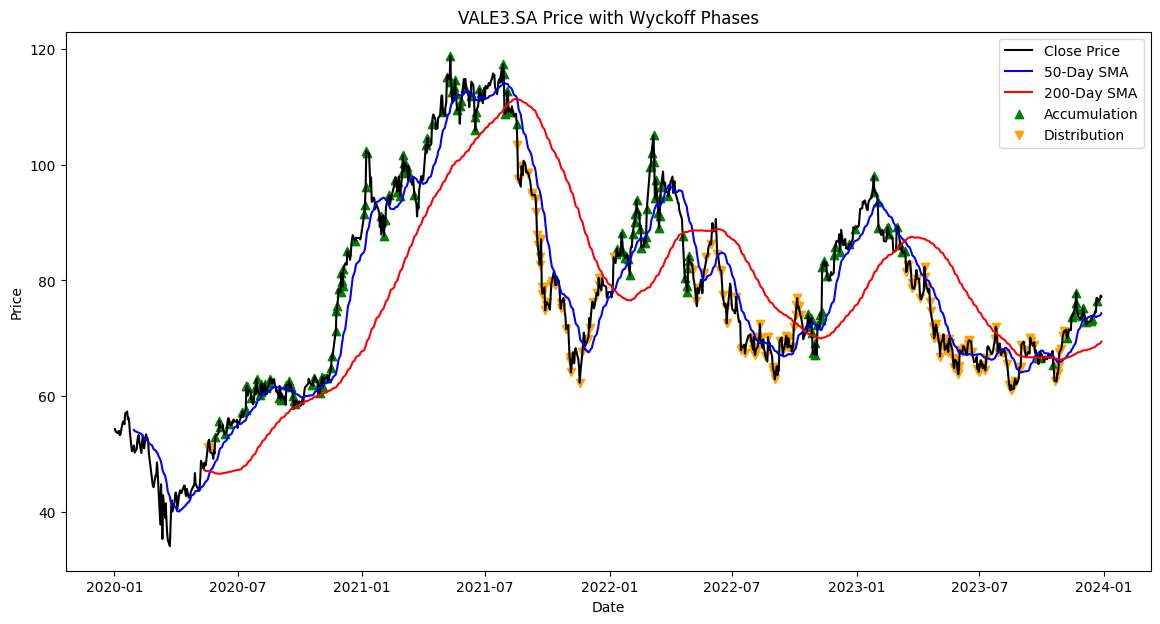

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Carregar dados históricos
def load_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['SMA_50'] = data['Close'].rolling(window=21).mean()
    data['SMA_200'] = data['Close'].rolling(window=90).mean()
    return data

# Identificar fases de acumulação e distribuição
def identify_phases(data):
    data['Phase'] = 'Undefined'

    for i in range(1, len(data)):
        # Fase de Acumulação
        if data['SMA_50'].iloc[i] > data['SMA_200'].iloc[i] and \
           data['Volume'].iloc[i] > data['Volume'].rolling(window=50).mean().iloc[i]:
            data.at[data.index[i], 'Phase'] = 'Accumulation'

        # Fase de Distribuição
        elif data['SMA_50'].iloc[i] < data['SMA_200'].iloc[i] and \
             data['Volume'].iloc[i] > data['Volume'].rolling(window=50).mean().iloc[i]:
            data.at[data.index[i], 'Phase'] = 'Distribution'

    return data

# Plotar gráficos
def plot_phases(data, ticker):
    plt.figure(figsize=(14, 7))

    plt.plot(data.index, data['Close'], label='Close Price', color='black')
    plt.plot(data.index, data['SMA_50'], label='50-Day SMA', color='blue')
    plt.plot(data.index, data['SMA_200'], label='200-Day SMA', color='red')

    accumulation = data[data['Phase'] == 'Accumulation']
    distribution = data[data['Phase'] == 'Distribution']

    plt.scatter(accumulation.index, accumulation['Close'], label='Accumulation', color='green', marker='^', alpha=1)
    plt.scatter(distribution.index, distribution['Close'], label='Distribution', color='orange', marker='v', alpha=1)

    plt.title(f'{ticker} Price with Wyckoff Phases')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Parâmetros de entrada
ticker = 'VALE3.SA'
start_date = '2020-01-01'
end_date = '2024-01-01'

# Executar funções
data = load_data(ticker, start_date, end_date)
data = identify_phases(data)
plot_phases(data, ticker)

[*********************100%%**********************]  1 of 1 completed


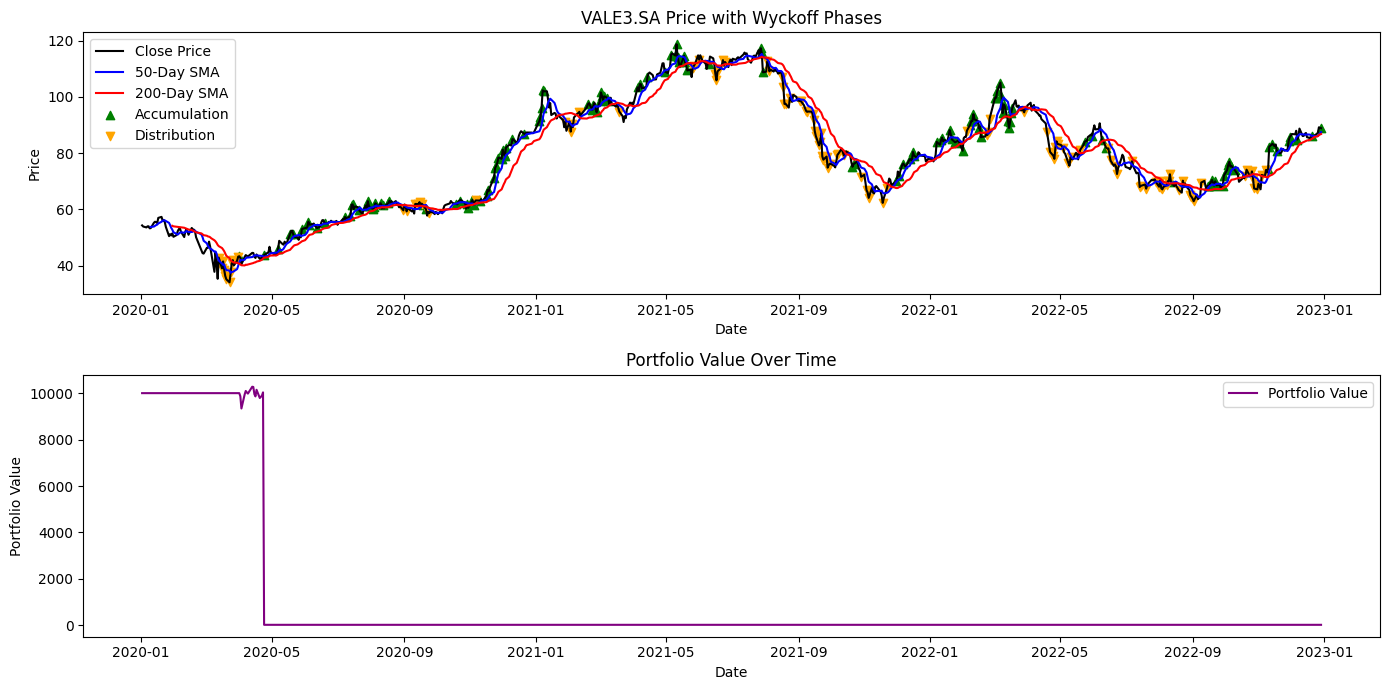

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Carregar dados históricos
def load_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['SMA_50'] = data['Close'].rolling(window=7).mean()
    data['SMA_200'] = data['Close'].rolling(window=21).mean()
    return data

# Identificar fases de acumulação e distribuição
def identify_phases(data):
    data['Phase'] = 'Undefined'

    for i in range(1, len(data)):
        # Fase de Acumulação
        if data['SMA_50'].iloc[i] > data['SMA_200'].iloc[i] and \
           data['Volume'].iloc[i] > data['Volume'].rolling(window=50).mean().iloc[i]:
            data.at[data.index[i], 'Phase'] = 'Accumulation'

        # Fase de Distribuição
        elif data['SMA_50'].iloc[i] < data['SMA_200'].iloc[i] and \
             data['Volume'].iloc[i] > data['Volume'].rolling(window=50).mean().iloc[i]:
            data.at[data.index[i], 'Phase'] = 'Distribution'

    return data

# Simular evolução do patrimônio
def simulate_portfolio(data, initial_cash):
    cash = initial_cash
    shares = 0
    portfolio_value = []
    buy_price = 0

    for i in range(len(data)):
        if data['Phase'].iloc[i] == 'Accumulation' and cash > 0:
            # Comprar ações
            shares = cash // data['Close'].iloc[i]
            buy_price = data['Close'].iloc[i]
            cash -= shares * buy_price
        elif data['Phase'].iloc[i] == 'Distribution' and shares > 0:
            # Vender ações
            sell_price = data['Close'].iloc[i]
            cash += shares * sell_price
            shares = 0
            buy_price = 0
        # Calcular valor do portfólio
        current_value = cash + shares * data['Close'].iloc[i]
        portfolio_value.append(current_value)

    data['Portfolio_Value'] = portfolio_value
    return data

# Plotar gráficos
def plot_phases_and_portfolio(data, ticker):
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.plot(data.index, data['Close'], label='Close Price', color='black')
    plt.plot(data.index, data['SMA_50'], label='50-Day SMA', color='blue')
    plt.plot(data.index, data['SMA_200'], label='200-Day SMA', color='red')

    accumulation = data[data['Phase'] == 'Accumulation']
    distribution = data[data['Phase'] == 'Distribution']

    plt.scatter(accumulation.index, accumulation['Close'], label='Accumulation', color='green', marker='^', alpha=1)
    plt.scatter(distribution.index, distribution['Close'], label='Distribution', color='orange', marker='v', alpha=1)

    plt.title(f'{ticker} Price with Wyckoff Phases')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(data.index, data['Portfolio_Value'], label='Portfolio Value', color='purple')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Parâmetros de entrada
ticker = 'VALE3.SA'
start_date = '2020-01-01'
end_date = '2023-01-01'
initial_cash = 10000  # Dinheiro inicial para investir

# Executar funções
data = load_data(ticker, start_date, end_date)
data = identify_phases(data)
data = simulate_portfolio(data, initial_cash)
plot_phases_and_portfolio(data, ticker)

[*********************100%%**********************]  1 of 1 completed
<ipython-input-3-3d02f427ec82>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Return'] = data['Close'].pct_change()
<ipython-input-3-3d02f427ec82>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SMA_50'] = data['Close'] / data['SMA_50'] - 1
<ipython-input-3-3d02f427ec82>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

              precision    recall  f1-score   support

           0       0.52      0.58      0.54       445
           1       0.54      0.48      0.51       463

    accuracy                           0.53       908
   macro avg       0.53      0.53      0.53       908
weighted avg       0.53      0.53      0.53       908



A saída de streaming foi truncada nas últimas 5000 linhas.
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/p

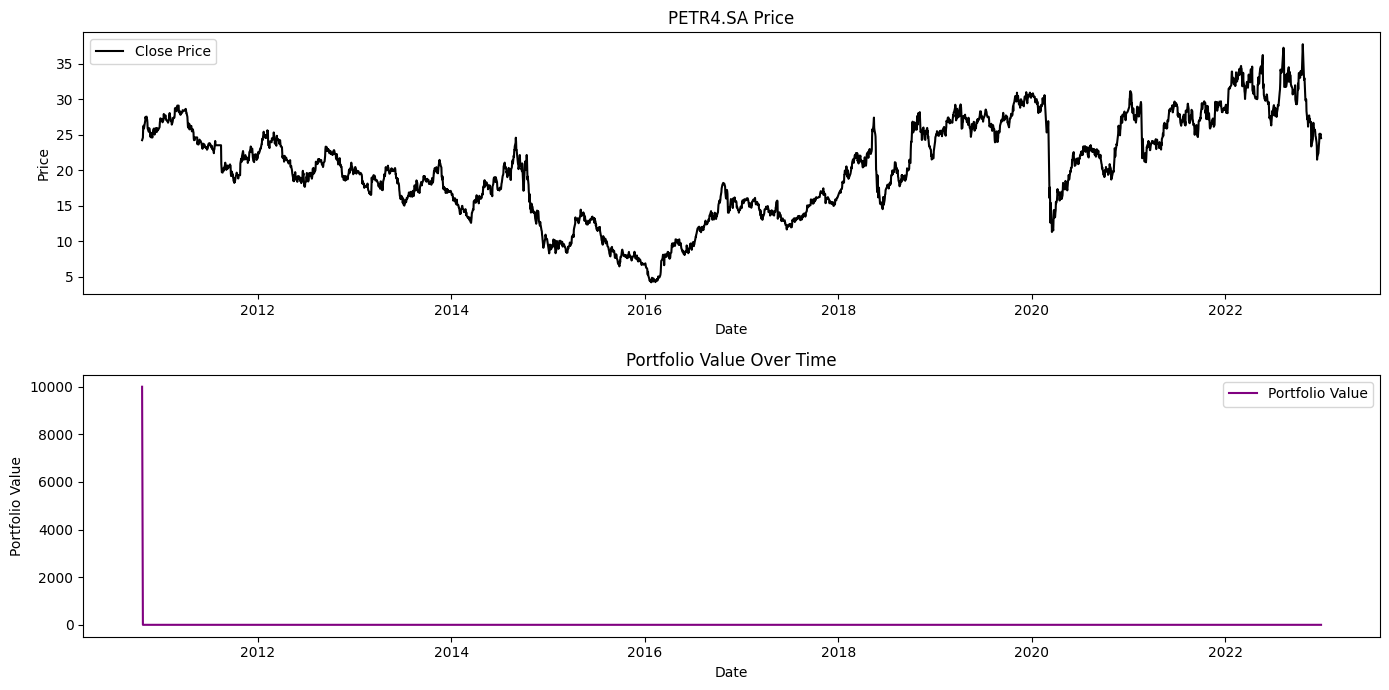

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Carregar dados históricos
def load_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['Volume_MA_50'] = data['Volume'].rolling(window=50).mean()
    return data.dropna()

# Criar features
def create_features(data):
    data['Return'] = data['Close'].pct_change()
    data['SMA_50'] = data['Close'] / data['SMA_50'] - 1
    data['SMA_200'] = data['Close'] / data['SMA_200'] - 1
    data['Volume'] = data['Volume'] / data['Volume_MA_50'] - 1
    data['Target'] = np.where(data['Return'].shift(-1) > 0, 1, 0)
    return data.dropna()

# Treinar modelo
def train_model(data):
    features = ['SMA_50', 'SMA_200', 'Volume']
    X = data[features]
    y = data['Target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    return model

# Simular evolução do patrimônio
def simulate_trades(data, model, initial_cash):
    cash = initial_cash
    shares = 0
    portfolio_value = []

    for i in range(len(data)):
        if model.predict([data.iloc[i][['SMA_50', 'SMA_200', 'Volume']]]) == 1 and cash > 0:
            # Comprar ações
            shares = cash // data['Close'].iloc[i]
            cash -= shares * data['Close'].iloc[i]
        elif model.predict([data.iloc[i][['SMA_50', 'SMA_200', 'Volume']]]) == 0 and shares > 0:
            # Vender ações
            cash += shares * data['Close'].iloc[i]
            shares = 0

        current_value = cash + shares * data['Close'].iloc[i]
        portfolio_value.append(current_value)

    data['Portfolio_Value'] = portfolio_value
    return data

# Plotar gráficos
def plot_results(data, ticker):
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.plot(data.index, data['Close'], label='Close Price', color='black')
    plt.title(f'{ticker} Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(data.index, data['Portfolio_Value'], label='Portfolio Value', color='purple')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Parâmetros de entrada
ticker = 'PETR4.SA'
start_date = '2010-01-01'
end_date = '2023-01-01'
initial_cash = 10000  # Dinheiro inicial para investir

# Executar funções
data = load_data(ticker, start_date, end_date)
data = create_features(data)
model = train_model(data)
data = simulate_trades(data, model, initial_cash)
plot_results(data, ticker)

In [ ]:
# -*- coding: utf-8 -*-

#instalando as bibliotecas
!pip install pycaret
!pip install yfinance

from pycaret.utils import enable_colab
enable_colab()

#importar as bibliotecas
import yfinance as yf
import pandas as pd

#escolher uma ação
df = yf.Ticker('RADL3.SA')
#escolher o intervalo de dados
raia = df.history(period='2y')
raia

#retirando os campos
raia = raia.drop(['Dividends','Stock Splits'], axis=1)
raia

#criando novos campos
raia['MM7d'] = raia['Close'].rolling(window=7).mean().round(2)
raia['MM30d'] = raia['Close'].rolling(window=30).mean().round(2)
raia

#5 dias para previsao
raia_prever = raia.tail(5)
raia_prever

#retirar os ultimos 5 dias do df
raia.drop(raia.tail(5).index, inplace=True)
raia

#empurra para frente os valores das ações
raia['Close'] = raia['Close'].shift(-1)
raia

#Retirar os nulos
raia.dropna(inplace=True)
raia

#drop index
raia.reset_index(drop=True, inplace=True)
raia_prever.reset_index(drop=True, inplace=True)

raia

#import regression lib pycaret
from pycaret.regression import *
setup(data= raia, target='Close', session_id=123)

top3 = compare_models(n_select=3)

print(top3)

models()

ridge = create_model('ridge', fold=10)

lar = create_model('lar', fold=10)

br = create_model('br', fold=10)

#Tunning
ridge_params = { 'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
tunne_ridge = tune_model(ridge, n_iter=1000, optimize='RMSE', custom_grid=ridge_params)

tunne_lar = tune_model(lar, n_iter=1000, optimize = 'RMSE')

tunne_br = tune_model(br, n_iter=1000, optimize = 'RMSE')

#Grafico erros
plot_model(tunne_ridge, plot='error')

plot_model(tunne_ridge, plot='feature')

#Testando com dados de treinameto
predict_model(tunne_ridge)

#Finalizar o modelo
final_ridge_model = finalize_model(tunne_ridge)

#Previsao
prev = predict_model(final_ridge_model, data=raia_prever)
prev

#Salvando o modelo para utilizar com dados novos
save_model(final_ridge_model, 'Modelo Final Ridge Pycaret')

#Dados novos
novo_dado = yf.download('RADL3.SA', period='45d')
novo_dado

#retira campos
novo_dado = novo_dado.drop('Adj Close',axis = 1)
#retirar index
novo_dado.reset_index(drop=True, inplace=True)
#criar novos campos
novo_dado['MM7d'] = novo_dado['Close'].rolling(window=7).mean().round(2)
novo_dado['MM30d'] = novo_dado['Close'].rolling(window=30).mean().round(2)
novo_dado

novo_dado = novo_dado.tail(1)
novo_dado

#Reutilizando o modelo
saved_final_ridge_model = load_model('Modelo Final Ridge Pycaret')

#Prevendo novo dado
nova_previsao = predict_model(saved_final_ridge_model, data=novo_dado)
nova_previsao.head()

  Using cached pycaret-3.3.2-py3-none-any.whl (486 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
     ━━━━

ImportError: cannot import name 'enable_colab' from 'pycaret.utils' (/usr/local/lib/python3.10/dist-packages/pycaret/utils/__init__.py)

[*********************100%%**********************]  1 of 1 completed


ValueError: x and y must be the same size

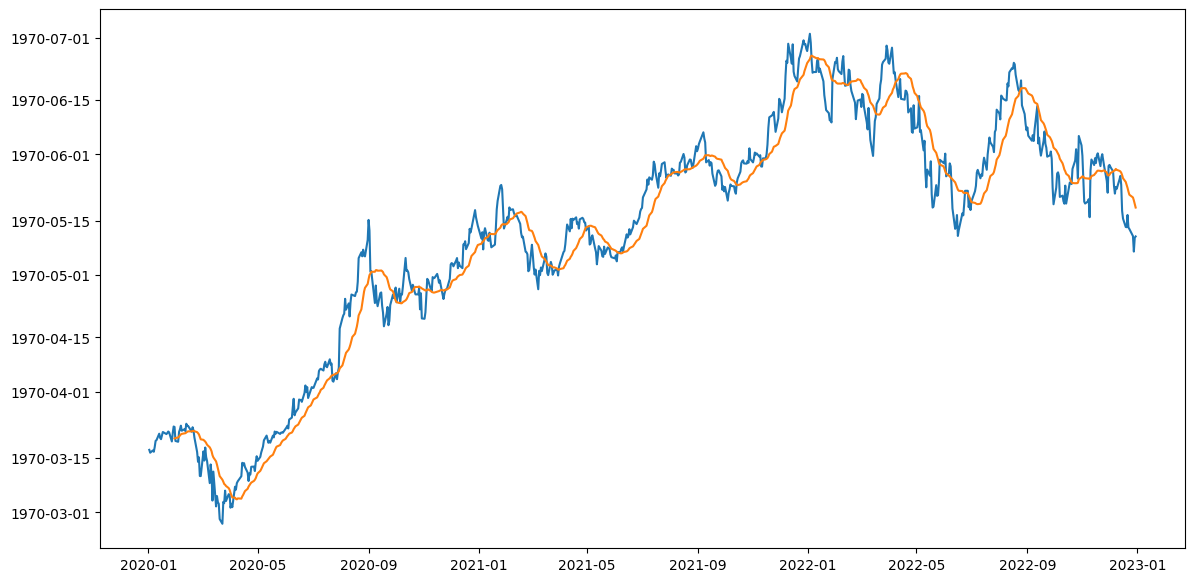

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Obtenha os dados históricos de um ativo (por exemplo, AAPL)
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

# Funções de cálculo
def calcula_SMA(precos, periodo):
    return precos.rolling(window=periodo).mean()

def calcula_desvio_padrao(precos, periodo):
    return precos.rolling(window=periodo).std()

def calcula_distorcao(preco_atual, sma, desvio_padrao):
    return (preco_atual - sma) / desvio_padrao

# Adicionando colunas ao DataFrame
data['SMA'] = calcula_SMA(data['Close'], 20)
data['DesvioPadrao'] = calcula_desvio_padrao(data['Close'], 20)
data['Distorcao'] = calcula_distorcao(data['Close'], data['SMA'], data['DesvioPadrao'])

# Definindo limites para alertas
limite_superior = 2
limite_inferior = -2

# Criação de alertas
data['Alerta'] = data['Distorcao'].apply(lambda x: 'Compra' if x < limite_inferior else ('Venda' if x > limite_superior else ''))

# Visualização
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Preço')
plt.plot(data.index, data['SMA'], label='SMA')
plt.scatter(data.index, data[data['Alerta'] == 'Compra'].index, data[data['Alerta'] == 'Compra']['Close'], label='Compra', marker='^', color='g')
plt.scatter(data.index, data[data['Alerta'] == 'Venda'].index, data[data['Alerta'] == 'Venda']['Close'], label='Venda', marker='v', color='r')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import requests

import time
from datetime import datetime


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


### FUNÇÃO PARA PEGAR TOKEN DE AUTENTICAÇÃO NA API
def get_token(email,senha):
    body = {"cavallari.luis@terra.com.br": email,"Hick+2020": senha}
    r = requests.post('https://api.oplab.com.br/v3/domain/users/authenticate',json=body)
    return r.json()['access-token']

### FUNÇÃO PARA COLETAR LISTA DE AÇÕES COM MAIOR LIQUIDEZ EM OPÇÕES
def pegar_mais_liqs(token,rank = 20):
    lista = []
    r = requests.get('https://api.oplab.com.br/v3/market/statistics/realtime/highest_options_volume?order_by=total&limit={}'.format(rank),headers={"Access-Token": token}).json()
    for i in r:
        lista.append(i['symbol'])
    return lista


### FUNÇÃO PARA COLETAR TODAS AS OPÇÕES DISPONÍVEIS POR ATIVO
def get_all_options(symbol,token):
    r = requests.get('https://api.oplab.com.br/v3/market/options/{}'.format(symbol), headers={"Access-Token": token})
    return r.json()


### FUNÇÃO PARA ORGANIZAR OPÇÕES EM UM DATAFRAME
def ofertas_opcoes(ativo,token,ask_dif_zero = 1):
    ### USAR ask_dif_zero = 1 PARA BUSCAR APENAS OPÇÕES COM OFERTA DE VENDA DISPONÍVEL
    symbol = []
    strike = []
    bid = []
    ask = []
    volume = []
    moneyness = []
    ativo_obj = []
    tipo = []
    vcto = []
    spot_price = []
    contract_size = []
    all_options = get_all_options(ativo,token)
    for i in range(len(all_options)):
        maturity = (datetime.strptime(all_options[i]['due_date'],"%Y-%m-%d")-datetime.today())
        if all_options[i]['strike'] >0 and (all_options[i]['ask'] > 0) == ask_dif_zero:
            p_spot = 0 if all_options[i]['spot_price'] == 0 else all_options[i]['spot_price']
            mnns = 0 if all_options[i]['spot_price'] == 0 else all_options[i]['strike'] / all_options[i]['spot_price'] -1
            symbol.append(all_options[i]['symbol'])
            tipo.append(all_options[i]['type'])
            strike.append(all_options[i]['strike'])
            bid.append(all_options[i]['bid'])
            ask.append(all_options[i]['ask'])
            volume.append(all_options[i]['volume'])
            moneyness.append(round(mnns*100,4))
            ativo_obj.append(ativo)
            vcto.append(maturity.days)
            spot_price.append(p_spot)
            contract_size.append(all_options[i]['contract_size'])

    ofertas = pd.DataFrame({'OBJ':ativo_obj,'OPÇÃO':symbol,'TIPO':tipo,'SPOT':spot_price,'STRIKE':strike,'BID':bid,'ASK':ask,'VOLUME':volume,'DIST_ATM':moneyness,'VCTO':vcto})
    return ofertas
#print(get_all_options(ativo,token))

### INSERIR EMAIL E SENHA --> get_token('seu@email.com','sua_senha')
try:
    token = 'QVsJS0d0PCAb+WLD1iRtqSR81lmR+yEIcJboUPGrMQIO/q0JWWwKE86GcU125M53--Oy3IvpegAph0hpCvxZ+7ow==--ZWY4ODJkY2ZlMjc5NWI2ZGQxNmI3Y2UyMzgzMzA4NmI='
except:
    print('TOKEN ERRADO')

### COLETAR LISTA DE 20 ATIVOS COM MAIOR LIQUIDEZ EM OPÇÕES
lista_ativos = pegar_mais_liqs(token,1)

 there### FILTRAR OPÇÕES COM MAIOR VOLUME
    for ativo in lista_ativos:
        ### REMOVER A LINHA ABAIXO PARA NÃO PULAR O IBOV
         if ativo == 'IBOV':
            continue
        ofertas = ofertas_opcoes(ativo,token,ask_dif_zero = 1)
        volume = []
        for x in list(ofertas['VOLUME']):
            if x not in volume:
                volume.append(x)
        volume.sort()
        if len(volume) <= 1:
            continue
        ### PRINTAR OS 12 MAIORES VOLUME DISPONÍVEIS
        try:
            print(ofertas[ofertas['VOLUME'] >= volume[-12]]) # Changed from volume[-12] to volume[-4] since there might not be 12 unique volumes.
        except IndexError:
            print(f"Not enough unique volumes for {ativo}. Printing all available:")
            print(ofertas)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 84)

In [ ]:
print(ofertas[ofertas['VCTO'] >= vencimentos[-2]])

NameError: name 'ofertas' is not defined

In [ ]:
!pip install om_quant_fin

INFO: pip is looking at multiple versions of om-quant-fin to determine which version is compatible with other requirements. This could take a while.


In [ ]:
import om_quant_fin as mql

#Download stock data:
  data = mql.download_data("AAPL", "2020-01-01", "2022-12-31")

#Calculates rolling Z-score:
  z_score = mql.rolling_z_score(data["Adj Close"], window = 20)

#Calculates rolling ratio:
  ratio = mql.rolling_ratio(data["Adj Close"], window = 20)

#Calculates returns:
  returns = mql.calculate_returns(data["Adj Close"], period = 1)

#Pain index
  window_size = 52 #rolling window for the pain index
  data["Pain_index"] = data["Adj Close"].rolling(window_size).apply(mql.pain_index, raw = True)
  mql.plot_pain_index(ticker1, data.index, data["Adj Close"], data["Pain_index"])

#Bootstrapping
  bs = mql.model_bs(model, x_train, y_train, x_test, y_test, n_iterations = 1000, range_bs = 0.1)
  mql.plot_bs(bs["accuracy_train"])
  mql.plot_bs(bs["accuracy_test"])

#qcut fit and transformer
labels = ["bin1", "bin2", "bin3", "bin4", "bin5", "bin6", "bin7", "bin8", "bin9", "bin10"
          ,"bin11", "bin12", "bin13", "bin14", "bin15", "bin16", "bin17", "bin18", "bin19", "bin20"]
qcut_transformer = mql.QCutTransformer(q = 20, labels = labels)
qcut_transformer.fit(data["column"])
qcut_transformer.transform(data["column"])

#Creates a data frame with 27 attributes for volatility estimation
start_date = = "2015-01-01"
end_date = "2023-12-31"
data = create_vars("^VIX", start_date, end_date, p = 10):
data.head(5)

#Creates a data frame with 27 attributes for volatility estimation
start_date = = "2015-01-01"
end_date = "2023-12-31"
data = create_vars("^VIX", start_date, end_date, p = 10):
data.head(5)

#Calculates the iFat
ifat, mstd = ifat(data["Returns"], p = 67)

IndentationError: unexpected indent (<ipython-input-4-816f7dabfa73>, line 4)

In [ ]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

    ### INSERIR EMAIL E SENHA --> get_token('seu@email.com','sua_senha')
try:
    token = 'QVsJS0d0PCAb+WLD1iRtqSR81lmR+yEIcJboUPGrMQIO/q0JWWwKE86GcU125M53--Oy3IvpegAph0hpCvxZ+7ow==--ZWY4ODJkY2ZlMjc5NWI2ZGQxNmI3Y2UyMzgzMzA4NmI='
except:
    print('TOKEN ERRADO')

### FUNÇÃO PARA COLETAR LISTA DE AÇÕES COM MAIOR LIQUIDEZ EM OPÇÕES
def pegar_mais_liqs(token,rank = 20):
    lista = []
    r = requests.get('https://api.oplab.com.br/v3/market/statistics/realtime/highest_options_volume?order_by={order_by}&limit={limit}'.format(rank),headers={"Access-Token": token}).json()

    for i in r:
        lista.append(i['symbol'])
    return lista

### FUNÇÃO PARA COLETAR TODAS AS OPÇÕES DISPONÍVEIS POR ATIVO
def get_all_options(symbol,token):
    lista_o = []
    r = requests.get('https://api.oplab.com.br/v3/market/options/{}'.format(symbol), headers={"Access-Token": token})
    for i in r:
        lista_o.append(i['symbol'])

    return lista_o


    print(lista_o)

In [ ]:
import requests

# Parâmetros da requisição
spot = 'PETR4'  # Substitua pelo ativo desejado
from_date = '2024-05-01'  # Data de início no formato YYYY-MM-DD
to_date = '2024-06-01'  # Data de fim no formato YYYY-MM-DD
symbol = 'PETR4F424'  # Substitua pelo símbolo da opção desejada

# Montar a URL da requisição
url = f'https://api.oplab.com.br/v3/market/historical/options/{spot}/{from_date}/{to_date}?symbol={symbol}'

# Cabeçalhos da requisição
headers = {
    'Access-Token': token
}

### INSERIR EMAIL E SENHA --> get_token('seu@email.com','sua_senha')
try:
    token = 'QVsJS0d0PCAb+WLD1iRtqSR81lmR+yEIcJboUPGrMQIO/q0JWWwKE86GcU125M53--Oy3IvpegAph0hpCvxZ+7ow==--ZWY4ODJkY2ZlMjc5NWI2ZGQxNmI3Y2UyMzgzMzA4NmI='
except:
    print('TOKEN ERRADO')

# Fazer a requisição GET
response = requests.get(url, headers=headers)

print(response)

<Response [200]>
